In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import regionmask
import seaborn as sns
from scipy.stats import linregress
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator
from scipy import stats

#### Extreme day selection

In [64]:
data=xr.open_dataset('CA_1984-2023_daily_pr_masked1.nc')
# dat=data['pr'].values
# dat_anom=(dat-dat.mean(axis=0))/dat.std(axis=0)
# day=pd.DataFrame({'time':[0], 'nwet':[0], 'ndry':[0], 'nreg':[0]})
# n_total=12233
# for k in range(dat_anom.shape[0]):
#     nwet=0
#     ndry=0
#     nreg=0
#     for i in range(dat_anom.shape[1]):
#         for j in range(dat_anom.shape[2]):
#             if dat_anom[k, i, j]>=2:
#                 nwet+=1
#             if dat_anom[k, i, j]<=-2:
#                 ndry+=1
#             if -2<dat_anom[k, i, j]<2:
#                 nreg+=1
#     df1=pd.DataFrame({'time':[data.time[k].values], 'nwet':[(nwet*100)/n_total], 'ndry':[(ndry*100)/n_total], 'nreg':[(nreg*100)/n_total]})
#     day=pd.concat([day, df1])
# day = day[day['time'] != 0]
# day['label'] = (day['nwet'] >= 10).astype(int)
# day.reset_index(drop=True, inplace=True)
# day.to_csv('extreme_event_days.csv')

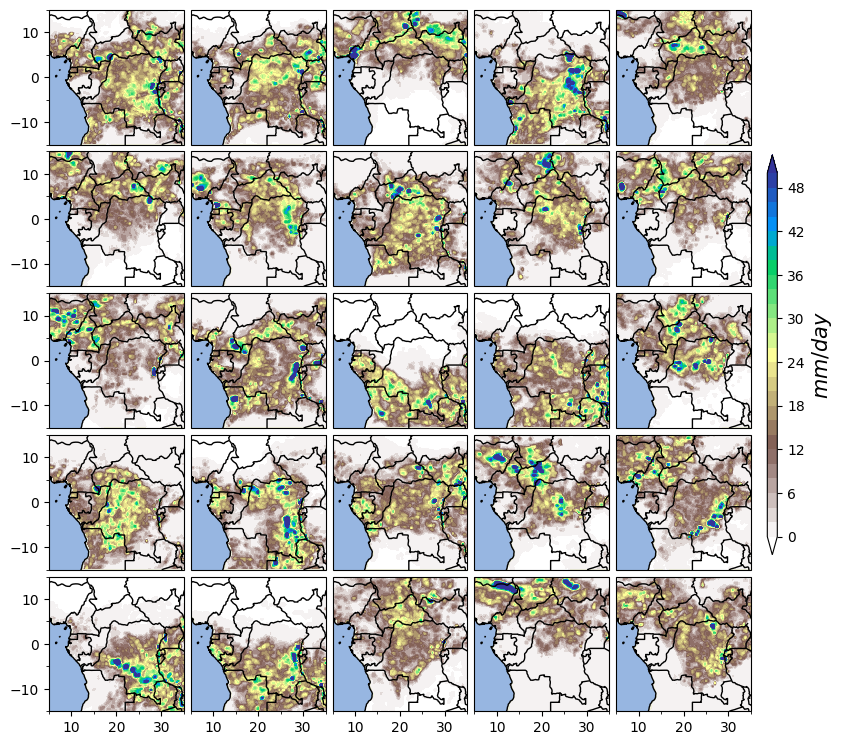

In [65]:
projection = ccrs.PlateCarree()
level=np.arange(0, 50.2, 2)
cmap='terrain_r'
fig = plt.figure(figsize=(10, 8))
df=pd.read_csv('extreme_event_days.csv')
df_reg=df[df['label']==1]
df_region=df_reg.sort_values(by='nwet', ascending=False)
df_region=np.array(pd.to_datetime(df_region['time']))
for k in range(25):
    ax = fig.add_subplot(5, 5, k+1, projection=projection)
    data_ex=data.where(data.time.isin([df_region[k]]), drop=True)
    mymap = ax.contourf(data.longitude, data.latitude, data_ex.pr[0, :, :], extend='both', cmap=cmap, levels=level)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.add_feature(cfeature.LAND.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    if k in [0, 5, 10, 15, 20]:
        ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
    if k in [20, 21, 22, 23, 24]:
        ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
plt.tight_layout(h_pad=+0.5, w_pad=-15, recdata_ex=data.where(data.time.isin([df_region[k]]), drop=True)t=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.88, 0.3, 0.01, 0.5])
cbar = plt.colorbar(mymap, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'$mm/day$', rotation=90, fontsize=15, fontweight='bold')
plt.savefig('../Figure/Figure0.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure0.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [68]:
len(df_region)

1063

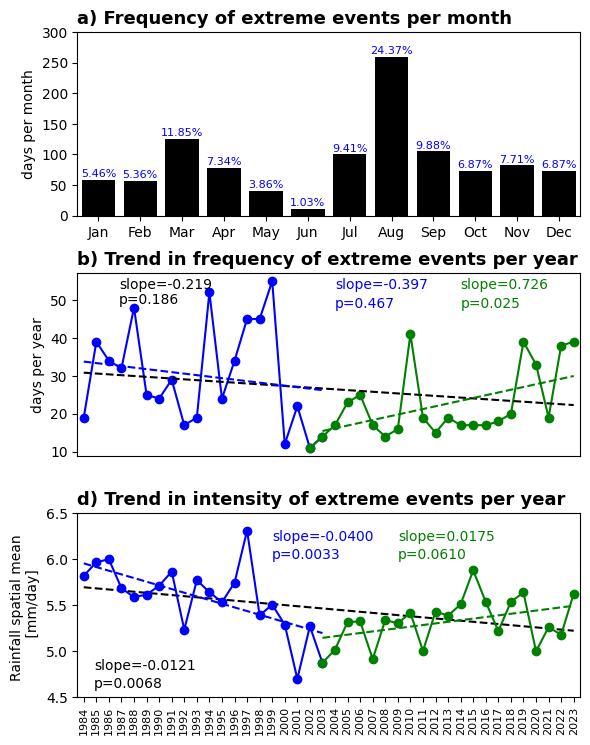

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
month_time=list(pd.to_datetime(df_reg['time']).dt.month)
year_time=list(pd.to_datetime(df_reg['time']).dt.year)
month=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year=[str(k) for k in np.arange(1984, 2024)]
years = np.arange(1984, 2024)
        
n_event_per_month=np.zeros(len(month))
for i in range(len(month)):
    n_event_per_month[i]=month_time.count(i+1)   
for i, valeur in enumerate(n_event_per_month):
    ax1.text(i, valeur + 1.5, f"{np.round((valeur/len(df_reg))*100, 2)}%", ha='center', va='bottom', color='blue', fontsize=8)
ax1.set_xlim(-0.5, 11.5)
ax1.set_ylim(0, 300)
ax1.set_ylabel('days per month')
ax1.bar(month, n_event_per_month, color='black')
ax1.set_title('a) Frequency of extreme events per month', fontsize=13, fontweight='bold', loc= 'left')
#ax1.text(-0.2, 260, 'a', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
n_event_per_year=np.zeros(len(year))
for i, y in enumerate([int(k) for k in year]):
    n_event_per_year[i]=year_time.count(y)

ax2.set_xlim(-0.5, 39.5)
ax2.set_ylabel('days per year')
ax2.set_xlabel('') 
ax2.set_xticks([])
ax2.plot(year[:-20], n_event_per_year[:-20], '-o', color='blue')
ax2.plot(year[18:], n_event_per_year[18:], '-o', color='green')
#ax2.set_title('Trend in frequency of extreme events per year')
ax2.set_title('b) Trend in frequency of extreme events per year', fontsize=13, fontweight='bold', loc= 'left')


slope, intercept, r_value, p_value, std_err = linregress(years, n_event_per_year)
ax2.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax2.text(2.8, 53, f'slope={slope:.3f}', color='black')
ax2.text(2.8, 49, f'p={p_value:.3f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], n_event_per_year[:-20])
ax2.plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax2.text(20, 53, f'slope={slope:.3f}', color='blue')
ax2.text(20, 48, f'p={p_value:.3f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], n_event_per_year[19:])
ax2.plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax2.text(30, 53, f'slope={slope:.3f}', color='green')
ax2.text(30, 48, f'p={p_value:.3f}', color='green')
#ax2.text(0.6, 51.2, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)


data_pos=data.where(data.time.isin([df_region]), drop=True)
pr_mean=data_pos.groupby("time.year").mean(dim=['time', 'latitude', 'longitude'])
pr_mean=pr_mean.pr.values

slope, intercept, r_value, p_value, std_err = linregress(years, pr_mean)
ax3.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax3.text(0.8, 4.8, f'slope={slope:.4f}', color='black')
ax3.text(0.8, 4.6, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], pr_mean[:-20])
ax3.plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax3.text(15, 6.2, f'slope={slope:.4f}', color='blue')
ax3.text(15, 6.0, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], pr_mean[19:])
ax3.plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax3.set_xlim(-0.5, 39.5)
ax3.set_ylim(4.5, 6.5)
ax3.set_ylabel('Rainfall spatial mean \n [mm/day]')
ax3.plot(year[:-20], pr_mean[:-20], '-o', color='blue')
ax3.plot(year[19:], pr_mean[19:], '-o', color='green')
ax3.text(25, 6.2, f'slope={slope:.4f}', color='green')
ax3.text(25, 6.0, f'p={p_value:.4f}', color='green')
#ax3.set_title('Trend in intensity of extreme events per year')
#ax3.text(0.5, 6.25, 'c', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax3.set_title('d) Trend in intensity of extreme events per year', fontsize=13, fontweight='bold', loc= 'left')

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout(h_pad=0.8, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/Figure1.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=300)
plt.savefig('../Figure/Figure1.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=300) 

/tmp/ipykernel_10011/4274642782.py:90: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])


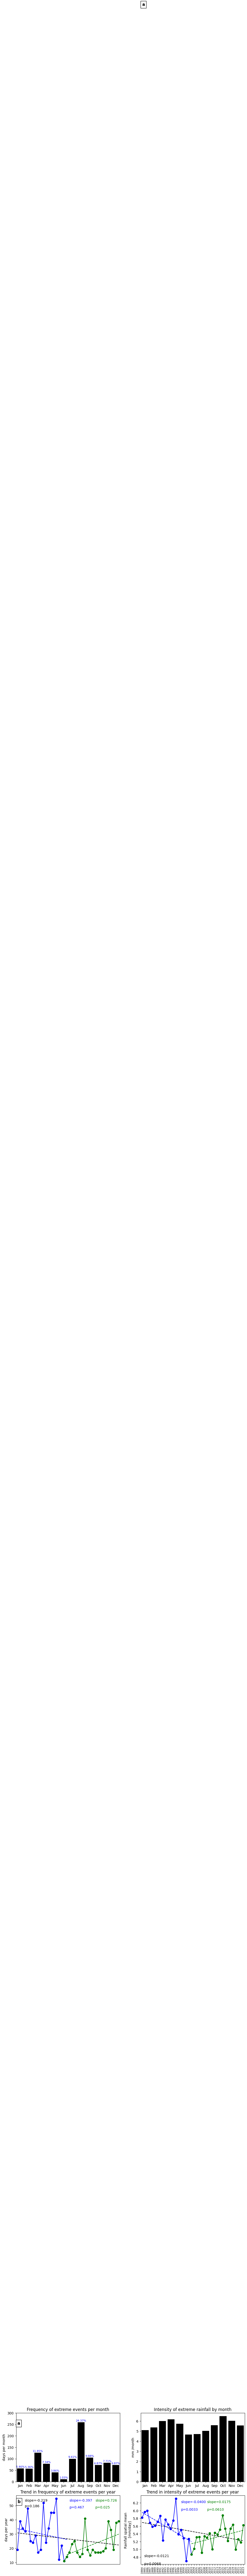

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
month_time=list(pd.to_datetime(df_reg['time']).dt.month)
year_time=list(pd.to_datetime(df_reg['time']).dt.year)
month=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year=[str(k) for k in np.arange(1984, 2024)]
years = np.arange(1984, 2024)
        
n_event_per_month=np.zeros(len(month))
for i in range(len(month)):
    n_event_per_month[i]=month_time.count(i+1)   
for i, valeur in enumerate(n_event_per_month):
    ax1.text(i, valeur + 1.5, f"{np.round((valeur/len(df_reg))*100, 2)}%", ha='center', va='bottom', color='blue', fontsize=8)
ax1.set_xlim(-0.5, 11.5)
ax1.set_ylim(0, 300)
ax1.set_ylabel('days per month')
ax1.bar(month, n_event_per_month, color='black')
ax1.set_title('Frequency of extreme events per month')
ax1.text(-0.2, 245, 'a', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)



data_pos=data.where(data.time.isin([df_region]), drop=True)
pr_sum=data_pos.groupby("time.month").mean(dim=['time', 'latitude', 'longitude'])
pr_sum=pr_sum.pr.values
ax2.set_xlim(-0.5, 11.5)
#ax2.set_ylim(0, 300)
ax2.set_ylabel('mm /month')
ax2.bar(month, pr_sum, color='black')
ax2.set_title('Intensity of extreme rainfall by month')
ax2.text(-0.2, 245, 'a', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)


n_event_per_year=np.zeros(len(year))
for i, y in enumerate([int(k) for k in year]):
    n_event_per_year[i]=year_time.count(y)

ax3.set_xlim(-0.5, 39.5)
ax3.set_ylabel('days per year')
ax3.set_xlabel('') 
ax3.set_xticks([])
ax3.plot(year[:-20], n_event_per_year[:-20], '-o', color='blue')
ax3.plot(year[18:], n_event_per_year[18:], '-o', color='green')
ax3.set_title('Trend in frequency of extreme events per year')

slope, intercept, r_value, p_value, std_err = linregress(years, n_event_per_year)
ax3.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax3.text(2.8, 53, f'slope={slope:.3f}', color='black')
ax3.text(2.8, 49, f'p={p_value:.3f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], n_event_per_year[:-20])
ax3.plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax3.text(20, 53, f'slope={slope:.3f}', color='blue')
ax3.text(20, 48, f'p={p_value:.3f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], n_event_per_year[19:])
ax3.plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax3.text(30, 53, f'slope={slope:.3f}', color='green')
ax3.text(30, 48, f'p={p_value:.3f}', color='green')
ax3.text(0.6, 51.2, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)


data_pos=data.where(data.time.isin([df_region]), drop=True)
pr_mean=data_pos.groupby("time.year").mean(dim=['time', 'latitude', 'longitude'])
pr_mean=pr_mean.pr.values

slope, intercept, r_value, p_value, std_err = linregress(years, pr_mean)
ax4.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax4.text(0.8, 4.8, f'slope={slope:.4f}', color='black')
ax4.text(0.8, 4.6, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], pr_mean[:-20])
ax4.plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax4.text(15, 6.2, f'slope={slope:.4f}', color='blue')
ax4.text(15, 6.0, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], pr_mean[19:])
ax4.plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax4.set_xlim(-0.5, 39.5)
#ax4.set_ylim(4.5, 6.5)
ax4.set_ylabel('Rainfall spatial mean \n [mm/day]')
ax4.plot(year[:-20], pr_mean[:-20], '-o', color='blue')
ax4.plot(year[19:], pr_mean[19:], '-o', color='green')
ax4.text(25, 6.2, f'slope={slope:.4f}', color='green')
ax4.text(25, 6.0, f'p={p_value:.4f}', color='green')
ax4.set_title('Trend in intensity of extreme events per year')
# ax3.text(0.5, 157, 'c', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)


plt.xticks(rotation=90, fontsize=8)
plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/Figure11.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=300)
plt.savefig('../Figure/Figure11.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=300) 

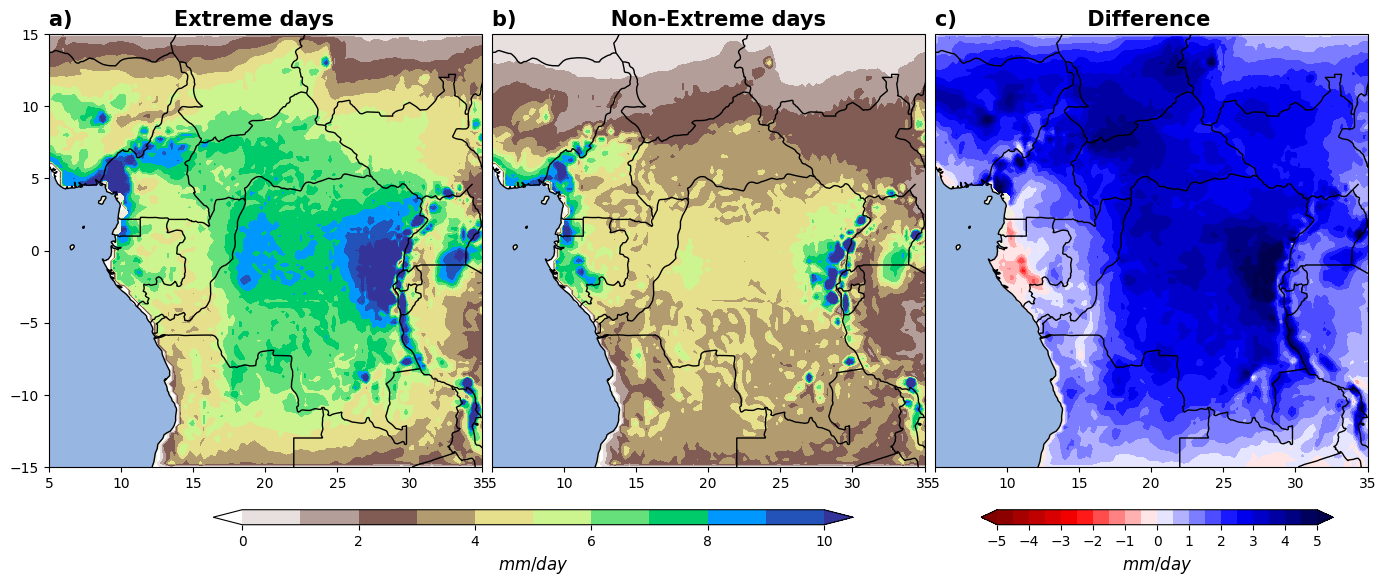

In [6]:
data=xr.open_dataset('CA_1984-2023_daily_pr_masked1.nc')
df=pd.read_csv('extreme_event_days.csv')
df_pos=df[df['label']==1]
df_region=np.array(pd.to_datetime(df_pos['time']))
df_neg=df[df['label']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['time']))

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 10))
lon=data.longitude
lat=data.latitude

past_year=np.arange(1984, 2004)
present_year=np.arange(2004, 2024)

level=np.arange(0, 11, 1)
level1=np.arange(-5, 5.5, 0.5)

levell=np.arange(30, 100, 5)
levell1=np.arange(-20, 25, 5)

cmap='terrain_r'
cmap1='seismic_r'

data_pos=data.where(data.time.isin([df_region]), drop=True)
data_pos_present=data_pos.where(data_pos.time.dt.year.isin([present_year]), drop=True)
data_pos_past=data_pos.where(data_pos.time.dt.year.isin([past_year]), drop=True)
data_pos=data_pos.pr.mean(axis=0)

data_neg=data.where(data.time.isin([df_region_neg]), drop=True)
data_neg=data_neg.pr.mean(axis=0)

delta=data_pos-data_neg

data_pos_present=data_pos_present.pr.mean(axis=0)
data_pos_past=data_pos_past.pr.mean(axis=0)
delta_time=data_pos_present-data_pos_past


ax = fig.add_subplot(2, 3, 1, projection=projection)
mymap = ax.contourf(lon, lat, data_pos, extend='both', cmap=cmap, levels=level)
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
#ax.text(7, 12, 'a', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
#ax.set_title('Extreme days', fontsize=13, fontweight='bold')
ax.set_title('a)              Extreme days', fontsize=15, fontweight='bold', loc='left')
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])

ax = fig.add_subplot(2, 3, 2, projection=projection)
mymap = ax.contourf(lon, lat, data_neg, extend='both', cmap=cmap, levels=level)
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax.text(7, 12, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax.set_title('b)             Non-Extreme days', fontsize=15, fontweight='bold', loc='left')
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])

ax = fig.add_subplot(2, 3, 3, projection=projection)
mymap1 = ax.contourf(lon, lat, delta, extend='both', cmap=cmap1, levels=level1)
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax.text(7, 12, 'c', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax.set_title('c)                  Difference', fontsize=15, fontweight='bold', loc='left')
#ax.set_title('Difference', fontsize=13, fontweight='bold')
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])

plt.tight_layout(h_pad=0, w_pad=-15, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.20, 0.47, 0.40, 0.015])
cbar = plt.colorbar(mymap, orientation='horizontal', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'$mm/day$', rotation=0, fontsize=12, fontweight='bold')

cbaxes = fig.add_axes([0.68, 0.47, 0.22, 0.015])
cbar = plt.colorbar(mymap1, orientation='horizontal', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'$mm/day$', rotation=0, fontsize=12, fontweight='bold')
ticks = np.arange(-5, 6, 1)
cbar.set_ticks(ticks)

plt.savefig('../Figure/Figure2.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure2.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


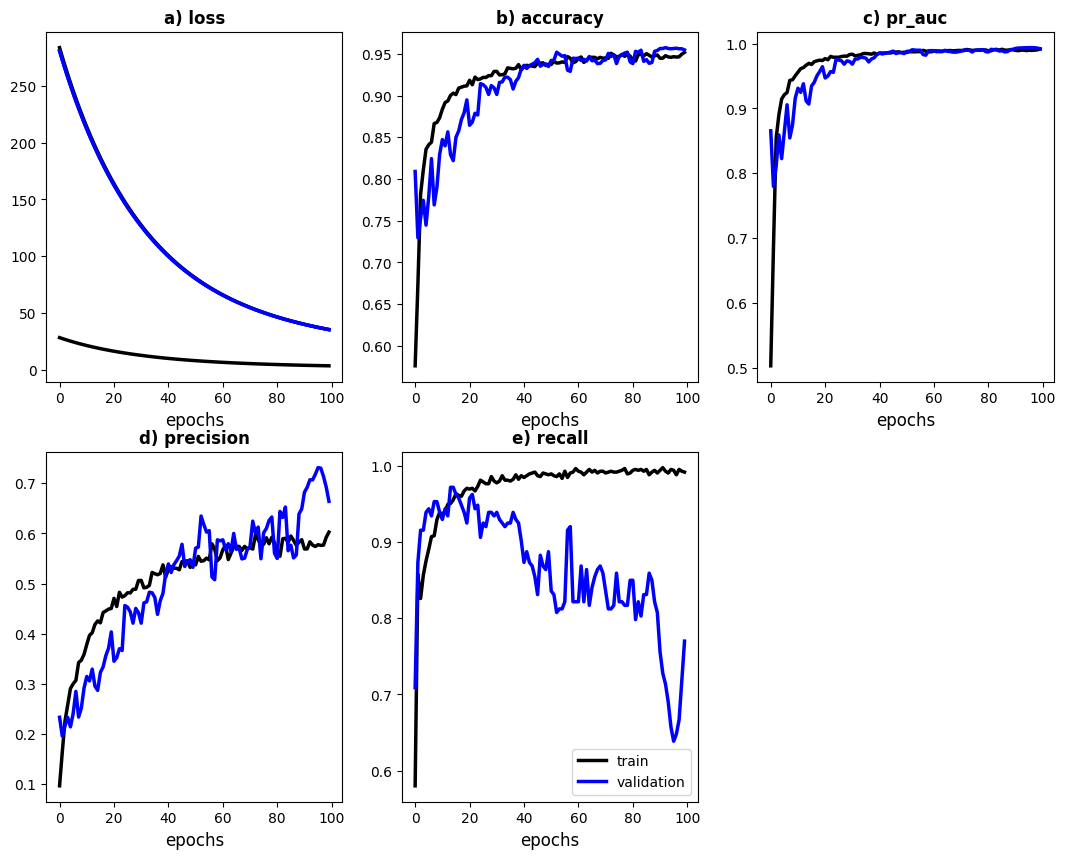

In [4]:
fig = plt.figure(figsize=(13, 10))
df=pd.read_csv('model_metrics.csv')
metrics=['loss', 'accuracy', 'pr_auc', 'precision', 'recall']
title=['a) loss', 'b) accuracy', 'c) pr_auc', 'd) precision', 'e) recall']
val_metrics=['val_loss', 'val_accuracy', 'val_pr_auc', 'val_precision', 'val_recall']
for k in range(len(metrics)):
    metric=df[metrics[k]]
    val_metric=df[val_metrics[k]]
    ax = fig.add_subplot(2, 3, k+1)
    ax.plot(metric, label='train', color='black', linewidth=2.5)
    ax.plot(val_metric, label='validation', color='blue', linewidth=2.5)
    if k==0:
        ax.plot(metric/10, label='train', color='black', linewidth=2.5)
        ax.plot(val_metric, label='validation', color='blue', linewidth=2.5)
    ax.set_title(title[k], fontsize=12, fontweight='bold')
    ax.set_xlabel('epochs', fontsize=12)
plt.legend()
plt.savefig('../Figure/Figure3a.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=300)
plt.savefig('../Figure/Figure3a.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=300)

In [5]:
df=pd.read_csv('model_predictions.csv')
data=xr.open_dataset('CA_1984-2023_daily_pr_masked.nc')
data_vimfc=xr.open_dataset('Vertical_Integrated_Moisture_convergence.nc')
data_rel=xr.open_dataset("lrp_relevance_pos_days.nc")
data_rel_n=xr.open_dataset("lrp_relevance_neg_days.nc")

In [6]:
df_pos=df[df['predicted_class']==1]
df_pos=df_pos.sort_values(by='prob_1', ascending=False)
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_neg=df_neg.sort_values(by='prob_0', ascending=False)
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

data_mean=data_vimfc.where(data_vimfc.time.isin([df_region]), drop=True)
data_mean=data_mean.VIMFC.mean(axis=0)
data_mean_1=data_vimfc.where(data_vimfc.time.isin([df_region[0]]), drop=True)
data_mean_1=data_mean_1.VIMFC.mean(axis=0)
data_mean_2=data_vimfc.where(data_vimfc.time.isin([df_region_neg[0]]), drop=True)
data_mean_2=data_mean_2.VIMFC.mean(axis=0)

data_lrp_mean=data_rel.vimfc.mean(axis=0)
data_lrp_1=data_rel.where(data_rel.time.isin([df_region[0]]), drop=True)
data_lrp_1=data_lrp_1.vimfc.mean(axis=0)
data_lrp_2=data_rel_n.where(data_rel_n.time.isin([df_region_neg[0]]), drop=True)
data_lrp_2=data_lrp_2.vimfc.mean(axis=0)

data_mean_pr=data.where(data.time.isin([df_region]), drop=True)
data_mean_pr=data_mean_pr.pr.mean(axis=0)
data_mean_pr_1=data.where(data.time.isin([df_region[0]]), drop=True)
data_mean_pr_1=data_mean_pr_1.pr.mean(axis=0)
data_mean_pr_2=data.where(data.time.isin([df_region_neg[0]]), drop=True)
data_mean_pr_2=data_mean_pr_2.pr.mean(axis=0)

1382

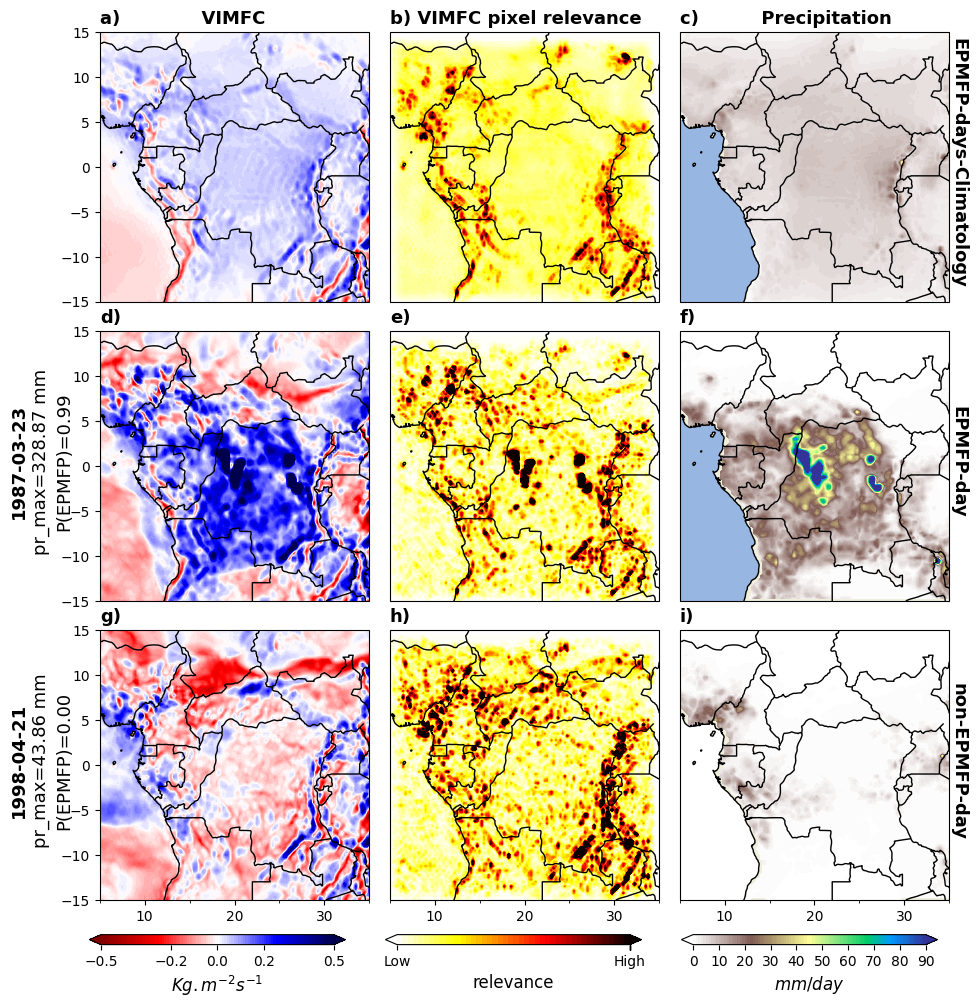

In [41]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 10))
lon=data_vimfc.lon
lat=data_vimfc.lat


level=np.arange(-0.5, 0.51, 0.01)
level1=np.arange(0, 0.045, 0.001)
level2=np.arange(0, 91, 1)

cmap='seismic_r'
cmap1='hot_r'
cmap2='terrain_r'


ax = fig.add_subplot(3, 3, 1, projection=projection)
mymap = ax.contourf(lon, lat, data_mean, extend='both', cmap=cmap, levels=level)
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
#ax.text(6.5, 12.5, 'a', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax.set_title('a)             VIMFC', fontsize=13, fontweight='bold', loc= 'left')


ax1 = fig.add_subplot(3, 3, 2, projection=projection)
mymap1 = ax1.contourf(lon, lat, data_lrp_mean*100, extend='both', cmap=cmap1, levels=level1)
ax1.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax1.add_feature(cfeature.BORDERS.with_scale('50m'))
ax1.add_feature(cfeature.LAND.with_scale('50m'))
ax1.add_feature(cfeature.OCEAN.with_scale('50m'))
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax1.text(6.5, 12.5, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax1.set_title('b) VIMFC pixel relevance', fontsize=13, fontweight='bold', loc= 'left')

ax2 = fig.add_subplot(3, 3, 3, projection=projection)
mymap2 = ax2.contourf(data.longitude, data.latitude, data_mean_pr, extend='both', cmap=cmap2, levels=level2)
ax2.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax2.add_feature(cfeature.BORDERS.with_scale('50m'))
ax2.add_feature(cfeature.LAND.with_scale('50m'))
ax2.add_feature(cfeature.OCEAN.with_scale('50m'))
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.text(35, 0.5, 'EPMFP-days-Climatology', rotation= -90, verticalalignment='center', fontsize=13, fontweight='bold')
#ax2.text(6.5, 12.5, 'c', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax2.set_title('c)          Precipitation', fontsize=13, fontweight='bold', loc= 'left')

ax = fig.add_subplot(3, 3, 4, projection=projection)
mymap = ax.contourf(lon, lat, data_mean_1, extend='both', cmap=cmap, levels=level)
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
ax.text(-5, 0.5, '1987-03-23', rotation=90, verticalalignment='center', fontsize=13, fontweight='bold')
ax.text(-2.5, 0.5, 'pr_max=328.87 mm', rotation=90, verticalalignment='center', fontsize=13)
ax.text(0, 0.5, 'P(EPMFP)=0.99', rotation=90, verticalalignment='center', fontsize=13)
#ax.text(6.5, 12.5, 'd', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax.set_title('d)', fontsize=13, fontweight='bold', loc= 'left')

ax1 = fig.add_subplot(3, 3, 5, projection=projection)
mymap1 = ax1.contourf(lon, lat, data_lrp_1*100, extend='both', cmap=cmap1, levels=level1)
ax1.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax1.add_feature(cfeature.BORDERS.with_scale('50m'))
ax1.add_feature(cfeature.LAND.with_scale('50m'))
ax1.add_feature(cfeature.OCEAN.with_scale('50m'))
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax1.text(6.5, 12.5, 'e', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax1.set_title('e)', fontsize=13, fontweight='bold', loc= 'left')

ax2 = fig.add_subplot(3, 3, 6, projection=projection)
mymap2 = ax2.contourf(data.longitude, data.latitude, data_mean_pr_1, extend='both', cmap=cmap2, levels=level2)
ax2.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax2.add_feature(cfeature.BORDERS.with_scale('50m'))
ax2.add_feature(cfeature.LAND.with_scale('50m'))
ax2.add_feature(cfeature.OCEAN.with_scale('50m'))
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.text(35, 0.5, 'EPMFP-day', rotation= -90, verticalalignment='center', fontsize=13, fontweight='bold')
#ax2.text(6.5, 12.5, 'f', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax2.set_title('f)', fontsize=13, fontweight='bold', loc= 'left')

ax = fig.add_subplot(3, 3, 7, projection=projection)
mymap = ax.contourf(lon, lat, data_mean_2, extend='both', cmap=cmap, levels=level)
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_yticks(np.arange(-15, 15, 5), [str(x) for x in np.arange(-15, 16, 5)])
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
ax.text(-5, 0.5, '1998-04-21', rotation=90, verticalalignment='center', fontsize=13, fontweight='bold')
ax.text(-2.5, 0.5, 'pr_max=43.86 mm', rotation=90, verticalalignment='center', fontsize=13)
ax.text(0, 0.5, 'P(EPMFP)=0.00', rotation=90, verticalalignment='center', fontsize=13)
#ax.text(6.5, 12.5, 'g', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax.set_title('g)', fontsize=13, fontweight='bold', loc= 'left')

ax1 = fig.add_subplot(3, 3, 8, projection=projection)
mymap1 = ax1.contourf(lon, lat, data_lrp_2*100, extend='both', cmap=cmap1, levels=level1)
ax1.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax1.add_feature(cfeature.BORDERS.with_scale('50m'))
ax1.add_feature(cfeature.LAND.with_scale('50m'))
ax1.add_feature(cfeature.OCEAN.with_scale('50m'))
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
#ax1.text(6.5, 12.5, 'h', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax1.set_title('h)', fontsize=13, fontweight='bold', loc= 'left')

ax2 = fig.add_subplot(3, 3, 9, projection=projection)
mymap2 = ax2.contourf(data.longitude, data.latitude, data_mean_pr_2, extend='both', cmap=cmap2, levels=level2)
ax2.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax2.add_feature(cfeature.BORDERS.with_scale('50m'))
ax2.add_feature(cfeature.LAND.with_scale('50m'))
ax1.add_feature(cfeature.OCEAN.with_scale('50m'))
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
ax2.text(35, 0.4, 'non-EPMFP-day', rotation= -90, verticalalignment='center', fontsize=13, fontweight='bold')
#ax2.text(6.5, 12.5, 'i', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax2.set_title('i)', fontsize=13, fontweight='bold', loc= 'left')

plt.tight_layout(h_pad=-0.1, w_pad=-40, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.23, 0.05, 0.16, 0.01])
cbar = plt.colorbar(mymap, orientation='horizontal', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'$Kg.m^{-2}s^{-1}$', rotation=0, fontsize=12, fontweight='bold')
ticks = [-0.5, -0.2, 0, 0.2, 0.5] 
cbar.set_ticks(ticks)

cbaxes = fig.add_axes([0.415, 0.05, 0.16, 0.01])
cbar = plt.colorbar(mymap1, orientation='horizontal', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'relevance', rotation=0, fontsize=12)
ticks = list(np.arange(0, 10))
cbar.set_ticks(ticks)
cbar.set_ticklabels(['Low', '', '', '', '', '', '', '', '', 'High'])


cbaxes = fig.add_axes([0.60, 0.05, 0.16, 0.01])
cbar = plt.colorbar(mymap2, orientation='horizontal', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r'$mm/day$', rotation=0, fontsize=12, fontweight='bold')
plt.savefig('../Figure/Figure4.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure4.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

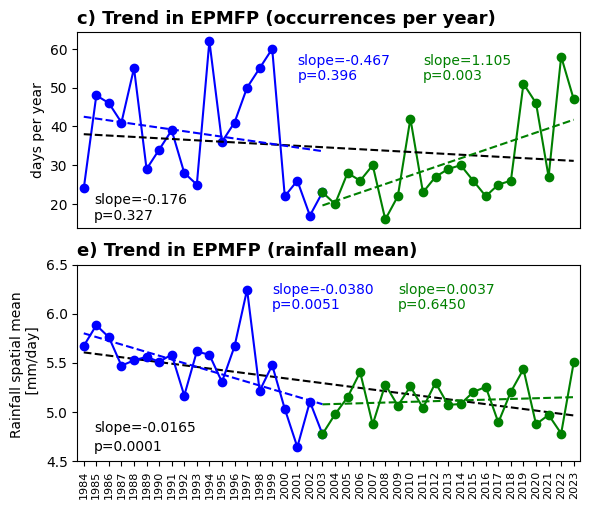

In [77]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5.5))
year=[str(k) for k in np.arange(1984, 2024)]
years = np.arange(1984, 2024)
df_pos=df[df['predicted_class']==1]
year_time=list(pd.to_datetime(df_pos['date']).dt.year)
df_region=np.array(pd.to_datetime(df_pos['date']))
n_event_per_year=np.zeros(len(year))
for i, y in enumerate([int(k) for k in year]):
    n_event_per_year[i]=year_time.count(y)

ax1.set_xlim(-0.5, 39.5)
ax1.set_ylabel('days per year')
ax1.set_xlabel('') 
ax1.set_xticks([])
ax1.plot(year[:-20], n_event_per_year[:-20], '-o', color='blue')
ax1.plot(year[19:], n_event_per_year[19:], '-o', color='green')
ax1.set_title('c) Trend in EPMFP (occurrences per year)', fontsize=13, fontweight="bold", loc='left')

slope, intercept, r_value, p_value, std_err = linregress(years, n_event_per_year)
ax1.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax1.text(0.8, 20, f'slope={slope:.3f}', color='black')
ax1.text(0.8, 16, f'p={p_value:.3f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], n_event_per_year[:-20])
ax1.plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax1.text(17, 56, f'slope={slope:.3f}', color='blue')
ax1.text(17, 52, f'p={p_value:.3f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], n_event_per_year[19:])
ax1.plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax1.text(27, 56, f'slope={slope:.3f}', color='green')
ax1.text(27, 52, f'p={p_value:.3f}', color='green')
#ax1.text(0.5, 58, 'a', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)


data_pos=data.where(data.time.isin([df_region]), drop=True)
pr_mean=data_pos.groupby("time.year").mean(dim=['time', 'latitude', 'longitude'])
pr_mean=pr_mean.pr.values

slope, intercept, r_value, p_value, std_err = linregress(years, pr_mean)
ax2.plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax2.text(0.8, 4.8, f'slope={slope:.4f}', color='black')
ax2.text(0.8, 4.6, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], pr_mean[:-20])
ax2.plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax2.text(15, 6.2, f'slope={slope:.4f}', color='blue')
ax2.text(15, 6.05, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], pr_mean[19:])
ax2.plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax2.set_xlim(-0.5, 39.5)
ax2.set_ylim(4.5, 6.5)


ax2.set_ylabel('Rainfall spatial mean \n [mm/day]')
ax2.plot(year[:-20], pr_mean[:-20], '-o', color='blue')
ax2.plot(year[19:], pr_mean[19:], '-o', color='green')
ax2.text(25, 6.2, f'slope={slope:.4f}', color='green')
ax2.text(25, 6.05, f'p={p_value:.4f}', color='green')
#ax2.text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
#ax2.set_title('Trend in EPMFP (rainfall mean)')
ax2.set_title('e) Trend in EPMFP (rainfall mean)', fontsize=13, fontweight="bold", loc='left')

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout(h_pad=+1, w_pad=0, rect=[0, 0.056, 1, 1])

plt.savefig('../Figure/Figure5.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure5.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [47]:
len(df_pos)

1382

/tmp/ipykernel_81653/3538129380.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])


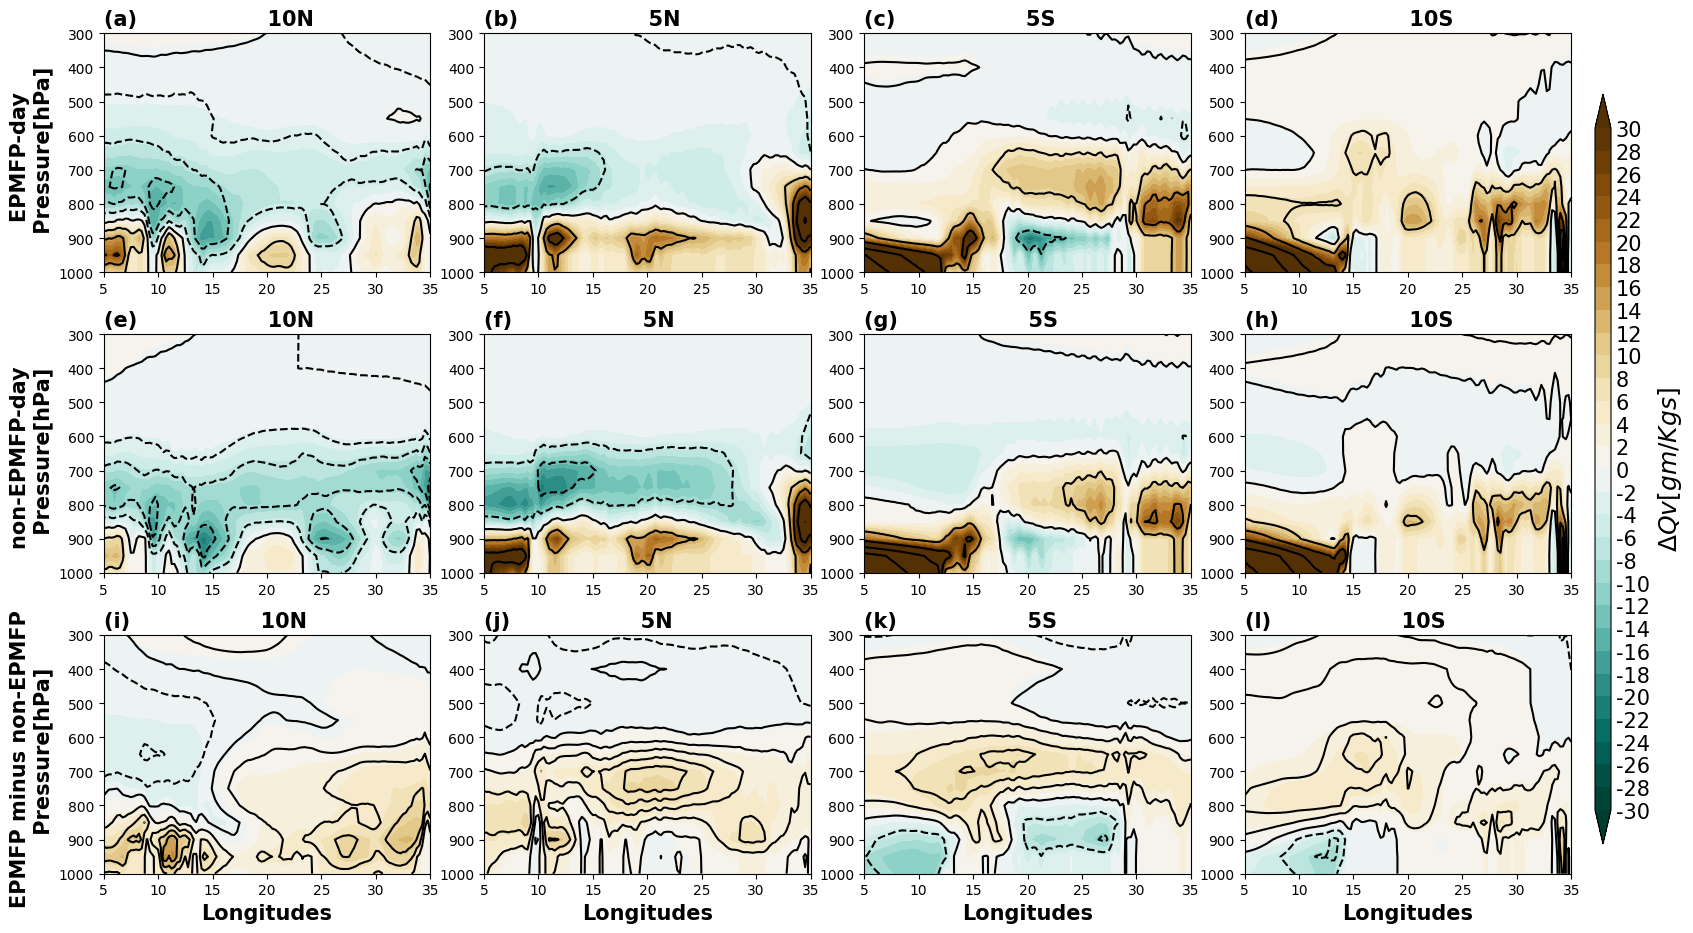

In [9]:
df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))


data=xr.open_dataset('CA_1984-2023_daily_quv.nc')

fig, ax = plt.subplots(3,4, figsize=(16, 10), facecolor='w', edgecolor='k')
lev = np.array([-3 -2, -1, -0.5, -0.1, 0, 1, 2, 3, 4])
# level=np.array([-6, -5, -4, -3, -2, -1, -0.5, 0.5, 1, 2, 3, 4, 5, 6])
level=np.arange(-30, 31, 2)

ticks=np.arange(-30, 31, 2)
lat_min=[9.8, 4.8, -5.1, -10.1]
lat_max=[10.1, 5.1, -4.8, -9.8]
past_year=np.arange(1984, 2002)
present_year=np.arange(2002, 2024)
cmap='BrBG_r'
title=['10N', '5N', '5S', '10S']
l1=['(a)', '(b)', '(c)', '(d)']
l2=['(e)', '(f)', '(g)', '(h)']
l3=['(i)', '(j)', '(k)', '(l)']

for j in range(3):
    for k in range(4):
        df=data.sel(lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))
        df=np.squeeze(df)
        df_pos=df.where(df.time.isin(df_region), drop=True)
        df_neg=df.where(df.time.isin(df_region_neg), drop=True)
        
        # df_pos_present=df_pos.where(df_pos.time.dt.year.isin(present_year), drop=True)
        # df_neg_present=df_neg.where(df_neg.time.dt.year.isin(present_year), drop=True)
        # df_pos_past=df_neg.where(df_pos.time.dt.year.isin(past_year), drop=True)
        # df_neg_past=df_neg.where(df_neg.time.dt.year.isin(past_year), drop=True)
        
        q_pos=df_pos.q.values.mean(axis=0)
        q_pos=q_pos*1000
        v_pos=df_pos.v.values.mean(axis=0)
        
        q_neg=df_neg.q.values.mean(axis=0)
        q_neg=q_neg*1000
        v_neg=df_neg.v.values.mean(axis=0)
        
        qv_pos= q_pos*v_pos
        qv_neg= q_neg*v_neg
        delta=qv_pos-qv_neg
        delta_v=v_pos-v_neg


        if j==0:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, qv_pos, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, v_pos, 6, colors='k')#, levels=lev)
            ax[j, k].set_title(l1[k]+' '*18+title[k], fontweight='bold', fontsize=15, loc='left')
            if k==0:
                ax[j, k].set_ylabel('EPMFP-day \n Pressure[hPa]', fontweight='bold', fontsize=15)
        if j==1:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, qv_neg, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, v_neg, 6, colors='k')#, levels=lev)
            ax[j, k].set_title(l2[k]+' '*18+title[k], fontweight='bold', fontsize=15, loc='left')
            if k==0:
                ax[j, k].set_ylabel('non-EPMFP-day \n Pressure[hPa]', fontweight='bold', fontsize=15)
        if j==2:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, delta, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_v, 6, colors='k')#, levels=lev)
            ax[j, k].set_title(l3[k]+' '*18+title[k], fontweight='bold', fontsize=15, loc='left')
            ax[j, k].set_xlabel('Longitudes', fontweight='bold', fontsize=15)
            if k==0:
                ax[j, k].set_ylabel('EPMFP minus non-EPMFP \n Pressure[hPa]', fontweight='bold', fontsize=15)

        ax[j, k].set_ylim(1000, 300)
        ax[j, k].set_xticks(np.arange(5, 36, 5), [str(k) for k in range(5, 36, 5)])
            
cbaxes = fig.add_axes([1.0, 0.15, 0.01, 0.75])
cbar = plt.colorbar(cont, orientation='vertical', cax = cbaxes, pad=0)
cbar.set_label(r'$\Delta Qv [g m / Kg s]$', rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=15, length=0)
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(x) for x in ticks])
plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/Figure6.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure6.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [19]:
lat_min=[-10.1, -5.1, 4.8, 9.8]
lat_max=[-9.8, -4.8, 5.1, 10.1]
val=[-10, -5, 5, 10]
for k in range(4):
    datal=data.sel(lev=slice(1000, 849), lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))
    datalp=datal.where(datal.time.isin(df_region), drop=True)
    q_pos=datalp.q.values.mean(axis=0)
    q_pos=q_pos*1000
    v_pos=datalp.v.values.mean(axis=0)
    df=q_pos*v_pos
    print(f"position={val[k]}, mena={df.mean()}, max={df.max()} and min={df.min()}")
    

position=-10, mena=12.221336256603633, max=61.93780254599324 and min=-7.755484474275941
position=-5, mena=8.2772960987024, max=64.74874596522571 and min=-21.27239583706399
position=5, mena=10.042737228498135, max=51.02482427114448 and min=-7.648693313531089
position=10, mena=0.5782043966103043, max=23.995158860816566 and min=-17.078838088098323


In [21]:
lat_min=[-10.1, -5.1, 4.8, 9.8]
lat_max=[-9.8, -4.8, 5.1, 10.1]
val=[-10, -5, 5, 10]
for k in range(4):
    datal=data.sel(lev=slice(1000, 849), lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))
    dataln=datal.where(datal.time.isin(df_region_neg), drop=True)
    q_pos=dataln.q.values.mean(axis=0)
    q_pos=q_pos*1000
    v_pos=dataln.v.values.mean(axis=0)
    df=q_pos*v_pos
    print(f"position={val[k]}, mena={df.mean()}, max={df.max()} and min={df.min()}")

position=-10, mena=12.473886132509518, max=65.67893617099858 and min=-6.8448130356146315
position=-5, mena=11.1838991347622, max=72.81843626731265 and min=-14.06270791558955
position=5, mena=7.714925337762326, max=46.69463445230921 and min=-11.128675417174987
position=10, mena=-4.365120933463298, max=12.879457466121089 and min=-20.600458767223774


In [22]:
lat_min=[-10.1, -5.1, 4.8, 9.8]
lat_max=[-9.8, -4.8, 5.1, 10.1]
val=[-10, -5, 5, 10]
for k in range(4):
    datal=data.sel(lev=slice(850, 301), lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))
    datalp=datal.where(datal.time.isin(df_region), drop=True)
    q_pos=datalp.q.values.mean(axis=0)
    q_pos=q_pos*1000
    v_pos=datalp.v.values.mean(axis=0)
    df=q_pos*v_pos
    print(f"position={val[k]}, mena={df.mean()}, max={df.max()} and min={df.min()}")

position=-10, mena=3.201779427377472, max=29.270795296689688 and min=-5.661427667538335
position=-5, mena=2.9602666438061793, max=29.364969734925943 and min=-7.199869942790792
position=5, mena=-2.2382283081009113, max=44.781311668134784 and min=-16.555648171114072
position=10, mena=-4.127141208084739, max=8.052497013764489 and min=-16.293462518849328


In [23]:
lat_min=[-10.1, -5.1, 4.8, 9.8]
lat_max=[-9.8, -4.8, 5.1, 10.1]
val=[-10, -5, 5, 10]
for k in range(4):
    datal=data.sel(lev=slice(850, 301), lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))
    dataln=datal.where(datal.time.isin(df_region_neg), drop=True)
    q_pos=dataln.q.values.mean(axis=0)
    q_pos=q_pos*1000
    v_pos=dataln.v.values.mean(axis=0)
    df=q_pos*v_pos
    print(f"position={val[k]}, mena={df.mean()}, max={df.max()} and min={df.min()}")

position=-10, mena=1.238062138256735, max=22.89853365478467 and min=-6.78816649562445
position=-5, mena=0.8155306273855772, max=25.800665827875427 and min=-5.971941421536277
position=5, mena=-4.277272834948226, max=42.4267053339464 and min=-20.961166406912856
position=10, mena=-4.806785831428044, max=0.10371418491818266 and min=-21.712846742765965


/tmp/ipykernel_65123/978929688.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])


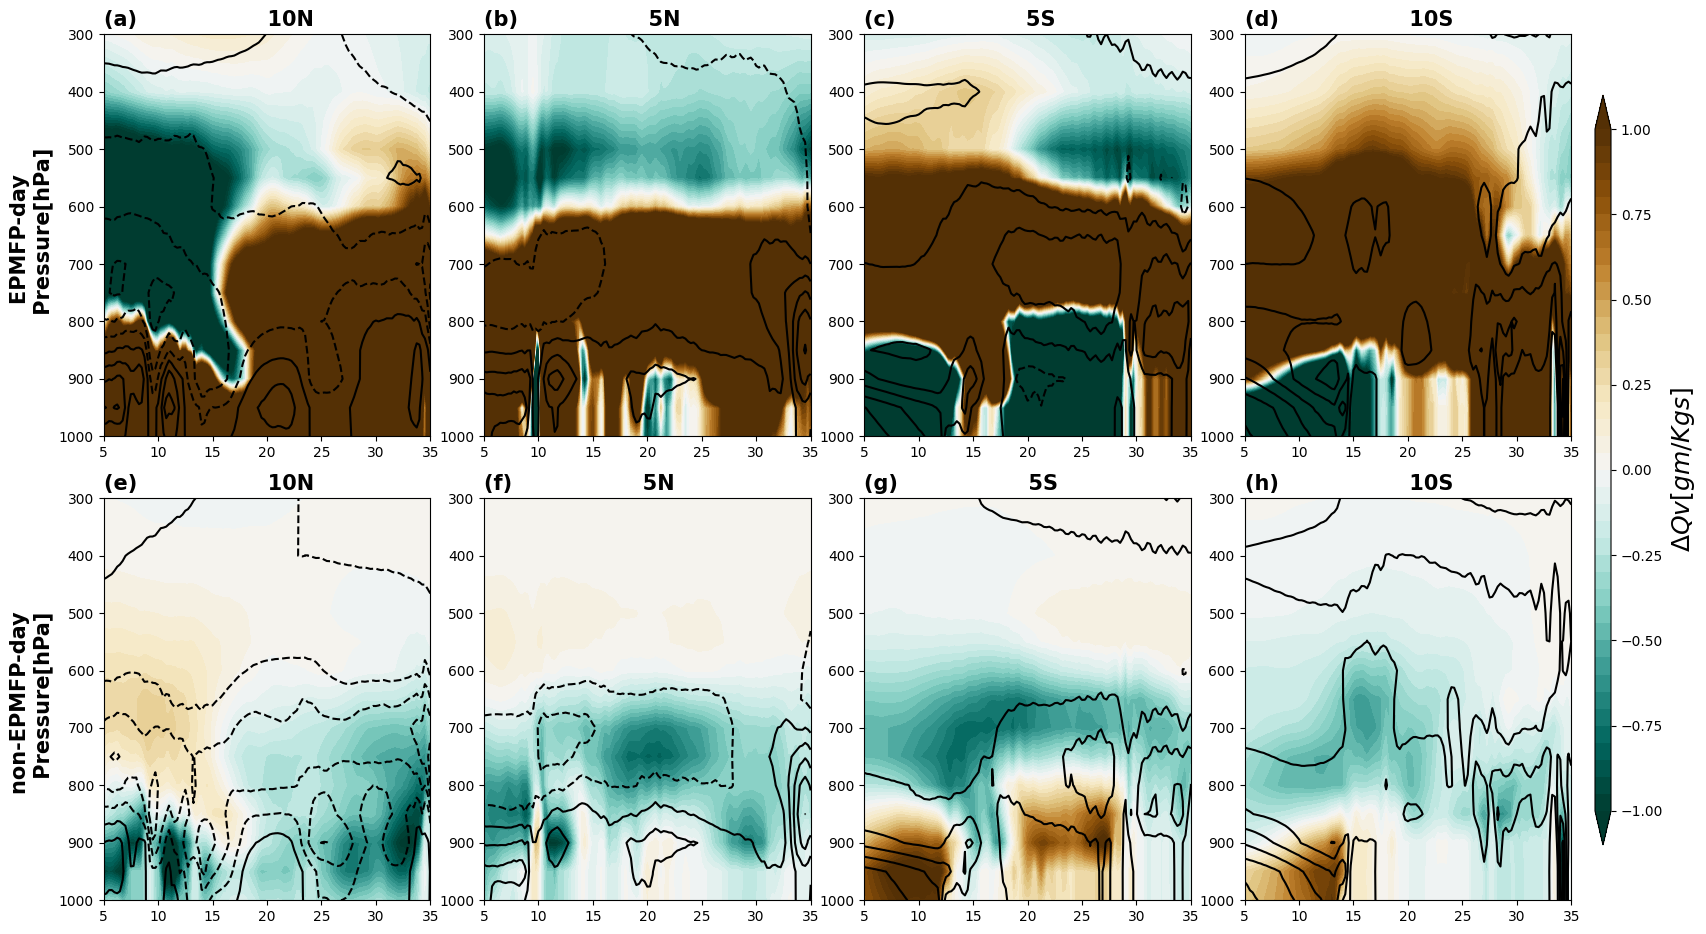

In [10]:
df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))


data=xr.open_dataset('CA_1984-2023_daily_quv.nc')

fig, ax = plt.subplots(2,4, figsize=(16, 10), facecolor='w', edgecolor='k')
lev = np.arange(-1, 1.05, 0.05)
# level=np.array([-6, -5, -4, -3, -2, -1, -0.5, 0.5, 1, 2, 3, 4, 5, 6])
# level=np.arange(-24, 25, 3)

ticks=np.arange(-24, 25, 3)
lat_min=[9.8, 4.8, -5.1, -10.1]
lat_max=[10.1, 5.1, -4.8, -9.8]
past_year=np.arange(1984, 2002)
present_year=np.arange(2002, 2024)
cmap='BrBG_r'
title=['10N', '5N', '5S', '10S']
l1=['(a)', '(b)', '(c)', '(d)']
l2=['(e)', '(f)', '(g)', '(h)']
l3=['(i)', '(j)', '(k)', '(l)']

for j in range(2):
    for k in range(4):
        df=data.sel(lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))

        data_clim=data.sel(lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))
        data_clim=np.squeeze(data_clim)
        
        df=np.squeeze(df)
        df_pos=df.where(df.time.isin(df_region), drop=True)
        df_neg=df.where(df.time.isin(df_region_neg), drop=True)
        
        # df_pos_present=df_pos.where(df_pos.time.dt.year.isin(present_year), drop=True)
        # df_neg_present=df_neg.where(df_neg.time.dt.year.isin(present_year), drop=True)
        # df_pos_past=df_neg.where(df_pos.time.dt.year.isin(past_year), drop=True)
        # df_neg_past=df_neg.where(df_neg.time.dt.year.isin(past_year), drop=True)
        
        q_pos=df_pos.q.values.mean(axis=0)
        q_pos=q_pos*1000
        v_pos=df_pos.v.values.mean(axis=0)
        
        q_neg=df_neg.q.values.mean(axis=0)
        q_neg=q_neg*1000
        v_neg=df_neg.v.values.mean(axis=0)

        data_clim_q=data_clim.q.values.mean(axis=0)
        data_clim_q=data_clim_q*1000
        data_clim_v=data_clim.v.values.mean(axis=0)
        
        qv_pos1= q_pos*v_pos
        qv_neg1= q_neg*v_neg

        data_clim_qv=data_clim_q*data_clim_v
        
        qv_pos=qv_pos1-data_clim_qv
        qv_neg=qv_neg1-data_clim_qv
        delta=qv_pos-qv_neg
        delta_v=v_pos-v_neg


        if j==0:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, qv_pos, cmap=cmap, levels=lev, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, v_pos, 6, colors='k')#, levels=lev)
            ax[j, k].set_title(l1[k]+' '*18+title[k], fontweight='bold', fontsize=15, loc='left')
            if k==0:
                ax[j, k].set_ylabel('EPMFP-day \n Pressure[hPa]', fontweight='bold', fontsize=15)
        if j==1:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, qv_neg, cmap=cmap, levels=lev, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, v_neg, 6, colors='k')#, levels=lev)
            ax[j, k].set_title(l2[k]+' '*18+title[k], fontweight='bold', fontsize=15, loc='left')
            if k==0:
                ax[j, k].set_ylabel('non-EPMFP-day \n Pressure[hPa]', fontweight='bold', fontsize=15)
        # if j==2:
        #     cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, delta, cmap=cmap, levels=level, extend='both')
        #     cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_v, 6, colors='k')#, levels=lev)
        #     ax[j, k].set_title(l3[k]+' '*18+title[k], fontweight='bold', fontsize=15, loc='left')
        #     if k==0:
        #         ax[j, k].set_ylabel('EPMFP minus non-EPMFP \n Pressure[hPa]', fontweight='bold', fontsize=15)

        ax[j, k].set_ylim(1000, 300)
        ax[j, k].set_xticks(np.arange(5, 36, 5), [str(k) for k in range(5, 36, 5)])
            
cbaxes = fig.add_axes([1.0, 0.15, 0.01, 0.75])
cbar = plt.colorbar(cont, orientation='vertical', cax = cbaxes, pad=0)
cbar.set_label(r'$\Delta Qv [g m / Kg s]$', rotation=90, fontsize=18)
# cbar.ax.tick_params(labelsize=15, length=0)
# cbar.set_ticks(ticks)
# cbar.set_ticklabels([str(x) for x in ticks])
plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/Figure6a.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure6a.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [4]:
data

<xarray.Dataset> Size: 67GB
Dimensions:  (time: 14610, lon: 121, lat: 121, lev: 13)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1984-01-01 1984-01-02 ... 2023-12-31
  * lon      (lon) float64 968B 5.0 5.25 5.5 5.75 6.0 ... 34.25 34.5 34.75 35.0
  * lat      (lat) float64 968B 15.0 14.75 14.5 14.25 ... -14.5 -14.75 -15.0
  * lev      (lev) float64 104B 1e+03 950.0 900.0 850.0 ... 500.0 400.0 300.0
Data variables:
    q        (time, lev, lat, lon) float64 22GB ...
    u        (time, lev, lat, lon) float64 22GB ...
    v        (time, lev, lat, lon) float64 22GB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Jan 02 10:29:44 2025: cdo mergetime merged_quv_output_o...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

/tmp/ipykernel_6908/1769794399.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])


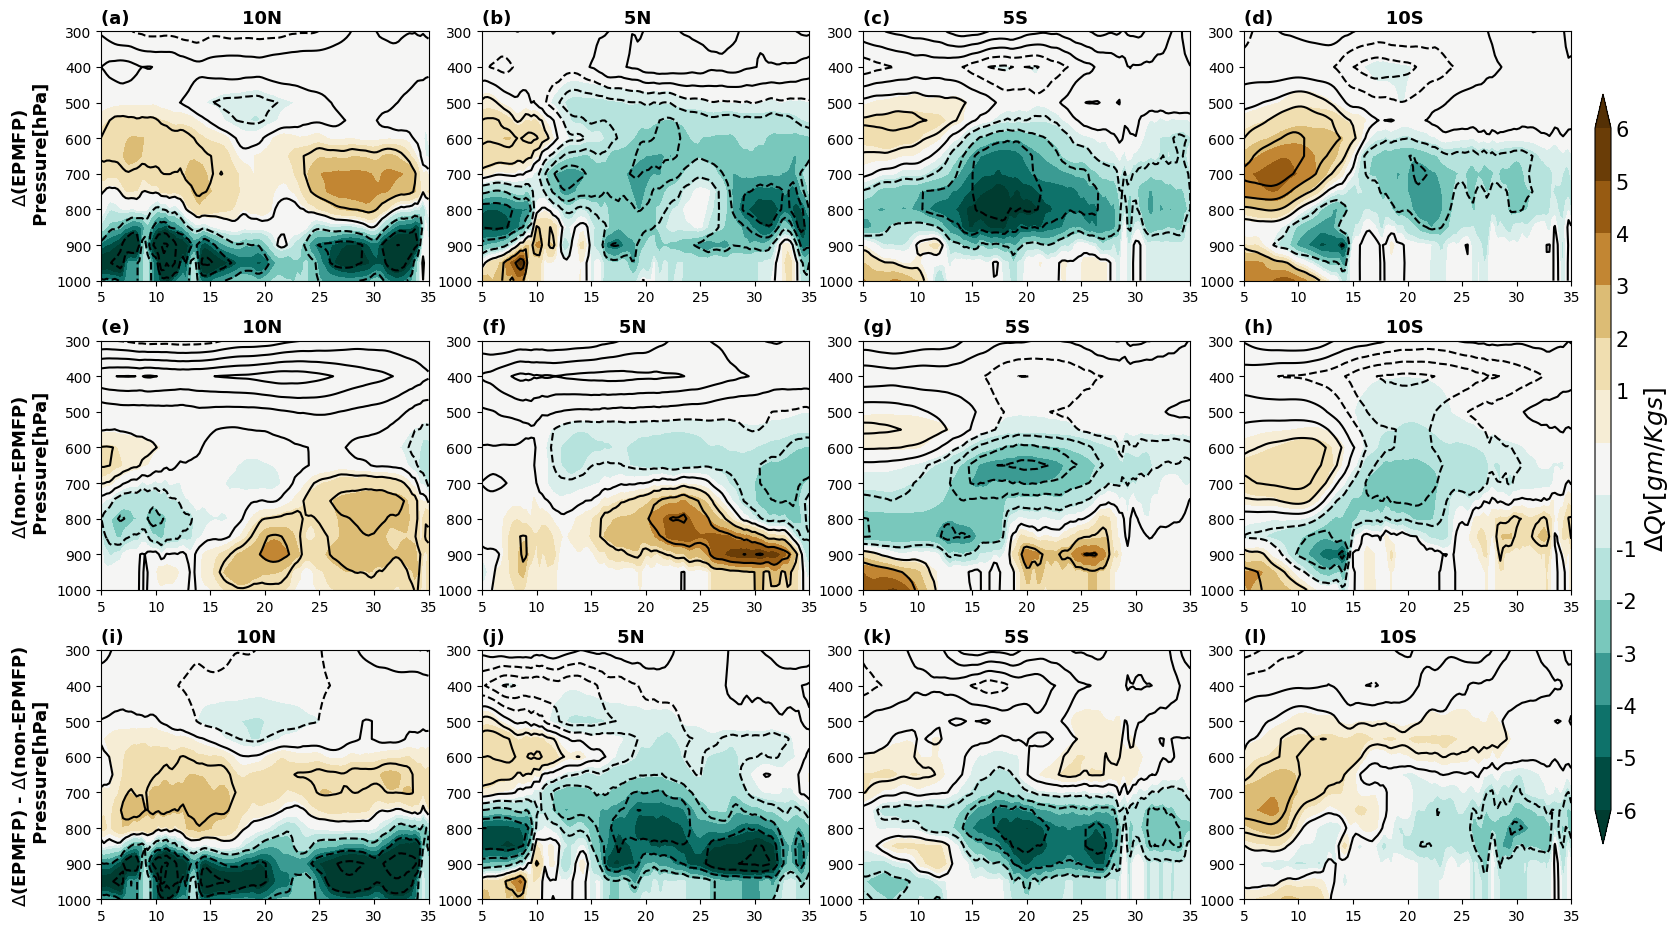

In [136]:
fig, ax = plt.subplots(3,4, figsize=(16, 10), facecolor='w', edgecolor='k')
data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
# lev = np.array([-3 -2, -1, -0.5, -0.1, 0, 1, 2, 3, 4])
level=np.array([-6, -5, -4, -3, -2, -1, -0.5, 0.5, 1, 2, 3, 4, 5, 6])

ticks=[-6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6]
lat_min=[9.8, 4.8, -5.1, -10.1]
lat_max=[10.1, 5.1, -4.8, -9.8]
past_year=np.arange(1984, 2002)
present_year=np.arange(2002, 2024)
cmap='BrBG_r'
title=['10N', '5N', '5S', '10S']
l1=['(a)', '(b)', '(c)', '(d)']
l2=['(e)', '(f)', '(g)', '(h)']
l3=['(i)', '(j)', '(k)', '(l)']
for j in range(3):
    for k in range(4):
        df=data.sel(lat=slice(lat_max[k], lat_min[k]), lon=slice(5, 35))
        df=np.squeeze(df)
        df_pos=df.where(df.time.isin(df_region), drop=True)
        df_neg=df.where(df.time.isin(df_region_neg), drop=True)
        
        df_pos_present=df_pos.where(df_pos.time.dt.year.isin(present_year), drop=True)
        df_neg_present=df_neg.where(df_neg.time.dt.year.isin(present_year), drop=True)
        df_pos_past=df_pos.where(df_pos.time.dt.year.isin(past_year), drop=True)
        df_neg_past=df_neg.where(df_neg.time.dt.year.isin(past_year), drop=True)
        
        q_pos_present=df_pos_present.q.values.mean(axis=0)
        q_pos_present=q_pos_present*1000
        v_pos_present=df_pos_present.v.values.mean(axis=0)
        q_pos_past=df_pos_past.q.values.mean(axis=0)
        q_pos_past=q_pos_past*1000
        v_pos_past=df_pos_past.v.values.mean(axis=0)
        
        q_neg_present=df_neg_present.q.values.mean(axis=0)
        q_neg_present=q_neg_present*1000
        v_neg_present=df_neg_present.v.values.mean(axis=0)
        q_neg_past=df_neg_past.q.values.mean(axis=0)
        q_neg_past=q_neg_past*1000
        v_neg_past=df_neg_past.v.values.mean(axis=0)
        
        qv_pos_present= q_pos_present*v_pos_present
        qv_pos_past= q_pos_past*v_pos_past
        qv_neg_present= q_neg_present*v_neg_present
        qv_neg_past= q_neg_past*v_neg_past

        delta_pos_qv=qv_pos_present-qv_pos_past
        delta_neg_qv=qv_neg_present-qv_neg_past

        delta_pos_q=q_pos_present-q_pos_past
        delta_neg_q=q_neg_present-q_neg_past

        delta_pos_v=v_pos_present-v_pos_past
        delta_neg_v=v_neg_present-v_neg_past

        delta_qv=delta_pos_qv-delta_neg_qv
        delta_q=delta_pos_q-delta_neg_q
        delta_v=delta_pos_v-delta_neg_v

        if j==0:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, delta_pos_qv, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_pos_v, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_pos_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l1[k]+' '*18+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel(r'$\Delta$'+'(EPMFP) \n Pressure[hPa]', fontweight='bold', fontsize=13)
        if j==1:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, delta_neg_qv, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_neg_v, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_neg_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l2[k]+' '*18+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel(r'$\Delta$'+'(non-EPMFP) \n Pressure[hPa]', fontweight='bold', fontsize=13)
        if j==2:
            cont = ax[j, k].contourf(df_pos.lon, df_pos.lev, delta_qv, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_v, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lon, df_pos.lev, delta_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l3[k]+' '*18+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel(r'$\Delta$'+'(EPMFP) - '+r'$\Delta$'+'(non-EPMFP) \n Pressure[hPa]', fontweight='bold', fontsize=13)

        ax[j, k].set_ylim(1000, 300) 
        ax[j, k].set_xticks(np.arange(5, 36, 5), [str(k) for k in range(5, 36, 5)])
            
cbaxes = fig.add_axes([1.0, 0.15, 0.01, 0.75])
cbar = plt.colorbar(cont, orientation='vertical', cax = cbaxes, pad=0)
cbar.set_label(r'$\Delta Qv [g m / Kg s]$', rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=15, length=0)
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(x) for x in ticks])
plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/FigureS1.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/FigureS1.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

/tmp/ipykernel_81653/737289705.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])


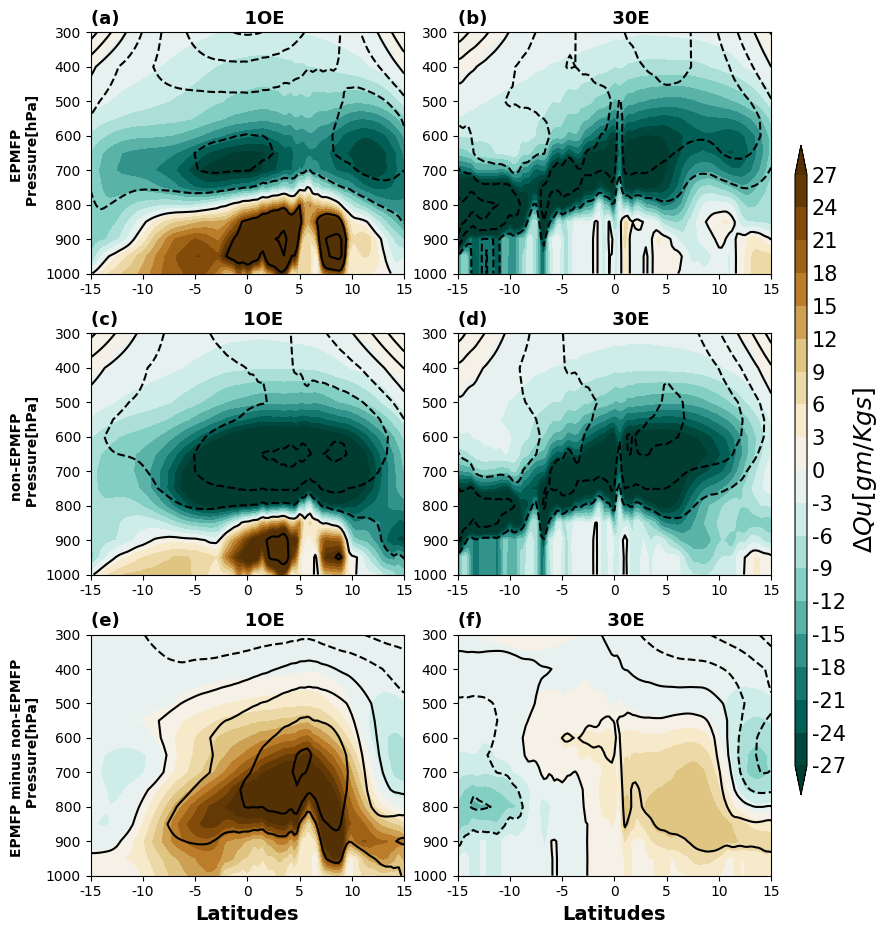

In [8]:
fig, ax = plt.subplots(3,2, figsize=(8, 10), facecolor='w', edgecolor='k')
data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
#lev = np.array([-3 -2, -1, -0.5, -0.1, 0, 1, 2, 3, 4])
level=np.arange(-27, 28, 3)

ticks=np.arange(-27, 28, 3)
lon_min=[9.8, 29.9]
lon_max=[10.1, 30.1]
past_year=np.arange(1984, 2002)
present_year=np.arange(2002, 2024)
cmap='BrBG_r'
title=['1OE', '30E']
l1=['(a)', '(b)']
l2=['(c)', '(d)']
l3=['(e)', '(f)']
for j in range(3):
    for k in range(2):
        df=data.sel(lat=slice(15, -15), lon=slice(lon_min[k], lon_max[k]))
        df=np.squeeze(df)
        df_pos=df.where(df.time.isin(df_region), drop=True)
        df_neg=df.where(df.time.isin(df_region_neg), drop=True)
        
        # df_pos_present=df_pos.where(df_pos.time.dt.year.isin(present_year), drop=True)
        # df_neg_present=df_neg.where(df_neg.time.dt.year.isin(present_year), drop=True)
        # df_pos_past=df_pos.where(df_pos.time.dt.year.isin(past_year), drop=True)
        # df_neg_past=df_neg.where(df_neg.time.dt.year.isin(past_year), drop=True)
        
        q_pos=df_pos.q.values.mean(axis=0)
        q_pos=q_pos*1000
        u_pos=df_pos.u.values.mean(axis=0)
        
        q_neg=df_neg.q.values.mean(axis=0)
        q_neg=q_neg*1000
        u_neg=df_neg.u.values.mean(axis=0)
        
        qu_pos= q_pos*u_pos
        qu_neg= q_neg*u_neg
        delta=qu_pos-qu_neg
        delta_u=u_pos-u_neg


        if j==0:
            cont = ax[j, k].contourf(df_pos.lat, df_pos.lev, qu_pos, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lat, df_pos.lev, u_pos, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_pos_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l1[k]+' '*20+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel('EPMFP \n Pressure[hPa]', fontweight='bold', fontsize=10)
        if j==1:
            cont = ax[j, k].contourf(df_pos.lat, df_pos.lev, qu_neg, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lat, df_pos.lev, u_neg, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_neg_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l2[k]+' '*20+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel('non-EPMFP \n Pressure[hPa]', fontweight='bold', fontsize=10)
        if j==2:
            cont = ax[j, k].contourf(df_pos.lat, df_pos.lev, delta, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_u, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l3[k]+' '*20+title[k], fontweight='bold', fontsize=13, loc='left')
            ax[j, k].set_xlabel('Latitudes', fontweight='bold', fontsize=14)
            if k==0:
                ax[j, k].set_ylabel('EPMFP minus non-EPMFP \n Pressure[hPa]', fontweight='bold', fontsize=10)

        ax[j, k].set_ylim(1000, 300)
        ax[j, k].set_xticks(np.arange(-15, 16, 5), [str(k) for k in range(-15, 16, 5)])
            
cbaxes = fig.add_axes([1.0, 0.20, 0.015, 0.65])
cbar = plt.colorbar(cont, orientation='vertical', cax = cbaxes, pad=0)
cbar.set_label(r'$\Delta Qu [g m / Kg s]$', rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=15, length=0)
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(x) for x in ticks])
plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/Figure7.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure7.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [82]:
df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lev=slice(851, 300))
data10=data.sel(lat=slice(15, -15), lon=slice(9.8, 10.1))
data10=np.squeeze(data10.mean(dim='lev'))

data10_pos=data10.where(data10.time.isin(df_region), drop=True)
data10_neg=data10.where(data10.time.isin(df_region_neg), drop=True)

In [84]:
data10_pos_q=data10_pos.q.values.mean(axis=0)
data10_pos_q=data10_pos_q*1000
data10_pos_u=data10_pos.u.values.mean(axis=0)

data10_neg_q=data10_neg.q.values.mean(axis=0)
data10_neg_q=data10_neg_q*1000
data10_neg_u=data10_neg.u.values.mean(axis=0)

qu_pos10= data10_pos_q*data10_pos_u
qu_neg10= data10_neg_q*data10_neg_u

print(f"maximum upper-level outflow {qu_neg10.min()}")
print(f"mean upper-level outflow {qu_neg10.mean()}")

maximum upper-level outflow -30.233086572812034
mean upper-level outflow -18.144969597171997


In [ ]:
print(qu_pos10.mean())

In [85]:
data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lev=slice(851, 300))
data30=data.sel(lat=slice(15, -15), lon=slice(29.8, 30.1))
data30=np.squeeze(data30.mean(dim='lev'))

data30_pos=data30.where(data30.time.isin(df_region), drop=True)
data30_neg=data30.where(data30.time.isin(df_region_neg), drop=True)

In [86]:
data30_pos_q=data30_pos.q.values.mean(axis=0)
data30_pos_q=data30_pos_q*1000
data30_pos_u=data30_pos.u.values.mean(axis=0)

data30_neg_q=data30_neg.q.values.mean(axis=0)
data30_neg_q=data30_neg_q*1000
data30_neg_u=data30_neg.u.values.mean(axis=0)

qu_pos30= data30_pos_q*data30_pos_u
qu_neg30= data30_neg_q*data30_neg_u
print(f"maximum upper-level inflow {qu_neg30.min()}")
print(f"mean upper-level inflow {qu_neg30.mean()}")

maximum upper-level inflow -28.12911365357668
mean upper-level inflow -16.225947429240623


In [81]:
print(qu_pos10.mean())#, qu_neg10.mean())
# print(qu_pos30.mean())#, qu_neg30.mean())

14.936100498008184


In [71]:
df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lev=slice(1000, 848))
data10=data.sel(lat=slice(15, -15), lon=slice(9.8, 10.1))
data10=np.squeeze(data10.mean(dim='lev'))

data10_pos=data10.where(data10.time.isin(df_region), drop=True)
data10_neg=data10.where(data10.time.isin(df_region_neg), drop=True)

In [72]:
data10_pos_q=data10_pos.q.values.mean(axis=0)
data10_pos_q=data10_pos_q*1000
data10_pos_u=data10_pos.u.values.mean(axis=0)

data10_neg_q=data10_neg.q.values.mean(axis=0)
data10_neg_q=data10_neg_q*1000
data10_neg_u=data10_neg.u.values.mean(axis=0)

qu_pos10= data10_pos_q*data10_pos_u
qu_neg10= data10_neg_q*data10_neg_u

print(qu_pos10.max(), np.where(qu_pos10 == qu_pos10.max()))
print(qu_neg10.max(), np.where(qu_neg10 == qu_neg10.max()))

50.80598446770211 (array([46]),)
34.92343955309784 (array([46]),)


In [76]:
print(qu_pos10.mean())
print(qu_neg10.mean())

14.936100498008184
3.1483851754608807


In [73]:
data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lev=slice(1000, 848))
data30=data.sel(lat=slice(15, -15), lon=slice(29.8, 30.1))
data30=np.squeeze(data30.mean(dim='lev'))

data30_pos=data30.where(data30.time.isin(df_region), drop=True)
data30_neg=data30.where(data30.time.isin(df_region_neg), drop=True)

In [75]:
data30_pos_q=data30_pos.q.values.mean(axis=0)
data30_pos_q=data30_pos_q*1000
data30_pos_u=data30_pos.u.values.mean(axis=0)

data30_neg_q=data30_neg.q.values.mean(axis=0)
data30_neg_q=data30_neg_q*1000
data30_neg_u=data30_neg.u.values.mean(axis=0)

qu_pos30= data30_pos_q*data30_pos_u
qu_neg30= data30_neg_q*data30_neg_u
print(qu_pos30.max(), np.where(qu_pos30 == qu_pos30.max()))
print(qu_neg30.max(), np.where(qu_neg30 == qu_neg30.max()))

5.71815660041712 (array([56]),)
0.619749059175519 (array([67]),)


/tmp/ipykernel_6908/3301192136.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])


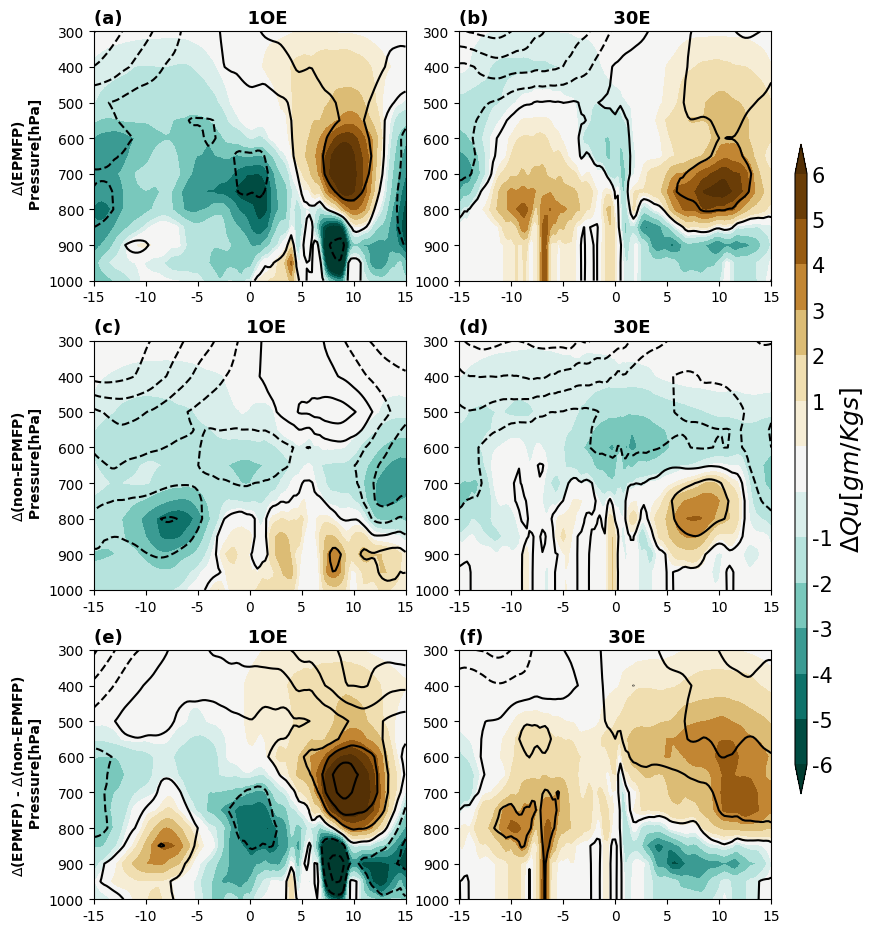

In [140]:
fig, ax = plt.subplots(3,2, figsize=(8, 10), facecolor='w', edgecolor='k')
data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
#lev = np.array([-3 -2, -1, -0.5, -0.1, 0, 1, 2, 3, 4])
level=np.array([-6, -5, -4, -3, -2, -1, -0.5, 0.5, 1, 2, 3, 4, 5, 6])

ticks=[-6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6]
lon_min=[9.8, 29.9]
lon_max=[10.1, 30.1]
past_year=np.arange(1984, 2002)
present_year=np.arange(2002, 2024)
cmap='BrBG_r'
title=['1OE', '30E']
l1=['(a)', '(b)']
l2=['(c)', '(d)']
l3=['(e)', '(f)']
for j in range(3):
    for k in range(2):
        df=data.sel(lat=slice(15, -15), lon=slice(lon_min[k], lon_max[k]))
        df=np.squeeze(df)
        df_pos=df.where(df.time.isin(df_region), drop=True)
        df_neg=df.where(df.time.isin(df_region_neg), drop=True)
        dt.time.isin(time_pmax.values
        df_pos_present=df_pos.where(df_pos.time.dt.year.isin(present_year), drop=True)
        df_neg_present=df_neg.where(df_neg.time.dt.year.isin(present_year), drop=True)
        df_pos_past=df_pos.where(df_pos.time.dt.year.isin(past_year), drop=True)
        df_neg_past=df_neg.where(df_neg.time.dt.year.isin(past_year), drop=True)
        
        q_pos_present=df_pos_present.q.values.mean(axis=0)
        q_pos_present=q_pos_present*1000
        u_pos_present=df_pos_present.u.values.mean(axis=0)
        q_pos_past=df_pos_past.q.values.mean(axis=0)
        q_pos_past=q_pos_past*1000
        u_pos_past=df_pos_past.u.values.mean(axis=0)
        
        q_neg_present=df_neg_present.q.values.mean(axis=0)
        q_neg_present=q_neg_present*1000
        u_neg_present=df_neg_present.u.values.mean(axis=0)
        q_neg_past=df_neg_past.q.values.mean(axis=0)
        q_neg_past=q_neg_past*1000
        u_neg_past=df_neg_past.u.values.mean(axis=0)
        
        qu_pos_present= q_pos_present*u_pos_present
        qu_pos_past= q_pos_past*u_pos_past
        qu_neg_present= q_neg_present*u_neg_present
        qu_neg_past= q_neg_past*u_neg_past

        delta_pos_qu=qu_pos_present-qu_pos_past
        delta_neg_qu=qu_neg_present-qu_neg_past

        delta_pos_q=q_pos_present-q_pos_past
        delta_neg_q=q_neg_present-q_neg_past

        delta_pos_u=u_pos_present-u_pos_past
        delta_neg_u=u_neg_present-u_neg_past

        delta_qu=delta_pos_qu-delta_neg_qu
        delta_q=delta_pos_q-delta_neg_q
        delta_u=delta_pos_u-delta_neg_u

        if j==0:
            cont = ax[j, k].contourf(df_pos.lat, df_pos.lev, delta_pos_qu, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_pos_u, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_pos_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l1[k]+' '*20+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel(r'$\Delta$'+'(EPMFP) \n Pressure[hPa]', fontweight='bold', fontsize=10)
        if j==1:
            cont = ax[j, k].contourf(df_pos.lat, df_pos.lev, delta_neg_qu, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_neg_u, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_neg_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l2[k]+' '*20+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel(r'$\Delta$'+'(non-EPMFP) \n Pressure[hPa]', fontweight='bold', fontsize=10)
        if j==2:
            cont = ax[j, k].contourf(df_pos.lat, df_pos.lev, delta_qu, cmap=cmap, levels=level, extend='both')
            cont1 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_u, 6, colors='k')#, levels=lev)
            #cont2 = ax[j, k].contour(df_pos.lat, df_pos.lev, delta_q, 6, colors='r')#, levels=lev)
            ax[j, k].set_title(l3[k]+' '*20+title[k], fontweight='bold', fontsize=13, loc='left')
            if k==0:
                ax[j, k].set_ylabel(r'$\Delta$'+'(EPMFP) - '+r'$\Delta$'+'(non-EPMFP) \n Pressure[hPa]', fontweight='bold', fontsize=10)

        ax[j, k].set_ylim(1000, 300)
        ax[j, k].set_xticks(np.arange(-15, 16, 5), [str(k) for k in range(-15, 16, 5)])
            
cbaxes = fig.add_axes([1.0, 0.20, 0.015, 0.65])
cbar = plt.colorbar(cont, orientation='vertical', cax = cbaxes, pad=0)
cbar.set_label(r'$\Delta Qu [g m / Kg s]$', rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=15, length=0)
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(x) for x in ticks])
plt.tight_layout(h_pad=1, w_pad=0, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/FigureS2.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/FigureS2.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [124]:
df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

data=xr.open_dataset('CA_1984-2023_daily_u_ok.nc')

data=data.sel(lev=slice(690, 649))
# data=data.mean(dim='lev')


data_pos=np.squeeze(data.where(data.time.isin(df_region), drop=True))
data_neg=np.squeeze(data.where(data.time.isin(df_region_neg), drop=True))

data_pos_SON=data_pos.where(data_pos.time.dt.month.isin([9, 10, 11]), drop=True)
data_neg_SON=data_neg.where(data_neg.time.dt.month.isin([9, 10, 11]), drop=True)

data_pos=data_pos.u.mean(axis=0)
data_neg=data_neg.u.mean(axis=0)

data_pos_SON=data_pos_SON.u.mean(axis=0)
data_neg_SON=data_neg_SON.u.mean(axis=0)

In [125]:
print(data_pos.min(), data_neg.min())

<xarray.DataArray 'u' ()> Size: 8B
array(-6.22087745)
Coordinates:
    lev      float64 8B 650.0 <xarray.DataArray 'u' ()> Size: 8B
array(-8.04554656)
Coordinates:
    lev      float64 8B 650.0


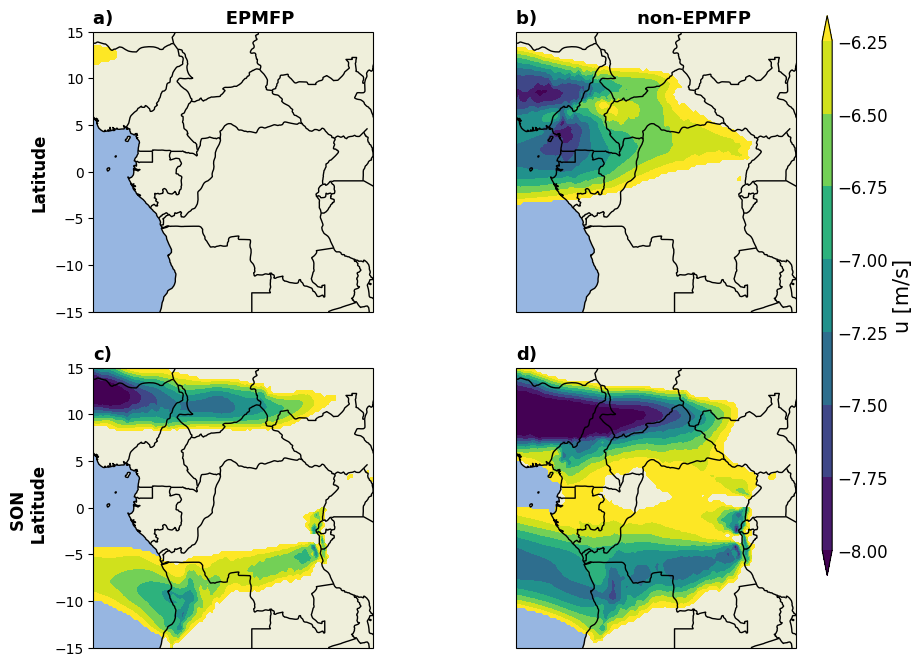

In [129]:
fig = plt.figure(figsize=(10, 8))
projection = ccrs.PlateCarree()

level=np.arange(-8, -6, 0.25)
# step=5
# level=np.arange(0, 7.25, 0.25)
cmap='seismic_r'
cmap1='Blues_r'

for i in range(data_pos.shape[0]):
    for j in range(data_pos.shape[1]):
        if data_pos[i, j]>=-6:
            data_pos[i, j]=np.nan  
            
ax = fig.add_subplot(2, 2, 1, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_pos, levels=level, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
# ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
# ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('a)'+' '*18+'EPMFP', fontsize=13, fontweight='bold', loc='left')

for i in range(data_neg.shape[0]):
    for j in range(data_neg.shape[1]):
        if data_neg[i, j]>=-6:
            data_neg[i, j]=np.nan
ax = fig.add_subplot(2, 2, 2, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_neg, levels=level, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
# ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
# ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_title('b)'+' '*16+'non-EPMFP', fontsize=13, fontweight='bold', loc='left')


for i in range(data_pos_SON.shape[0]):
    for j in range(data_pos_SON.shape[1]):
        if data_pos_SON[i, j]>=-6:
            data_pos_SON[i, j]=np.nan  
            
ax = fig.add_subplot(2, 2, 3, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_pos_SON, levels=level, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
#ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
ax.set_ylabel('SON \n Latitude', fontsize=12, fontweight='bold')
ax.set_title('c)', fontsize=13, fontweight='bold', loc='left')


for i in range(data_neg_SON.shape[0]):
    for j in range(data_neg_SON.shape[1]):
        if data_neg_SON[i, j]>=-6:
            data_neg_SON[i, j]=np.nan  
            
ax = fig.add_subplot(2, 2, 4, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_neg_SON, levels=level, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
#ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
# ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
# ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('d)', fontsize=13, fontweight='bold', loc='left')


# data1=xr.open_dataset('stream_func_eqq.nc')
# data_pos1=data1.where(data1.time.isin(df_region), drop=True)
# data_neg1=data1.where(data1.time.isin(df_region_neg), drop=True)

# data_pos1=data_pos1.siz.mean(axis=0)
# data_neg1=data_neg1.siz.mean(axis=0)

# for i in range(data_pos1.shape[0]):
#     for j in range(data_pos1.shape[1]):
#         if data_pos1[i, j]>=0:
#             data_pos1[i, j]=0
#         if data_neg1[i, j]>=0:
#             data_neg1[i, j]=0
# psi_z=data_pos1.mean(axis=1)
# psi_z=psi_z.sum().values.round(2)

# psi_z1=data_neg1.mean(axis=1)
# psi_z1=psi_z1.sum().values.round(2)

# ax = fig.add_subplot(3, 2, 5)
# ax.set_ylim(1000, 300)
# mymap1 = ax.contour(data1.lon, data1.lev,  data_pos1, cmap=cmap1, extend='both')
# mymap1 = ax.contourf(data1.lon, data1.lev,  data_pos1, cmap=cmap1, extend='both')
# ax.add_feature(cfeature.BORDERS.with_scale('50m'))
# ax.add_feature(cfeature.LAND.with_scale('50m'))
# ax.add_feature(cfeature.OCEAN.with_scale('50m'))
# ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
# ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
# ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
# ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
# ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
# ax.set_title('a)'+' '*20+'EPMFP', fontsize=13, fontweight='bold', loc='left')

# ax = fig.add_subplot(3, 2, 6)
# ax.set_ylim(1000, 300)
# ax.set_yticks([])
# mymap2 = ax.contourf(data1.lon, data1.lev,  data_neg1, cmap=cmap1, extend='both')
# mymap2 = ax.contour(data1.lon, data1.lev,  data_neg1, cmap=cmap1, extend='both')
# ax.add_feature(cfeature.BORDERS.with_scale('50m'))
# ax.add_feature(cfeature.LAND.with_scale('50m'))
# ax.add_feature(cfeature.OCEAN.with_scale('50m'))
# ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
# ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
# ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
# ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
# ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
# ax.set_title('a)'+' '*20+'EPMFP', fontsize=13, fontweight='bold', loc='left')

# ax.set_title(lab[k], fontsize=14, fontweight='bold', loc='left')
# q = ax.quiver(df1.longitude[::step], df1.latitude[::step], (iqu[::step, ::step]), (iqv[::step, ::step]), 
#                   pivot='mid', units='width', width=0.0025, scale=400)  

        
#plt.tight_layout(h_pad=0, w_pad=-10, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.89, 0.2, 0.01, 0.7])
cbar = plt.colorbar(mymap, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label('u [m/s]', rotation=90, fontsize=15)
cbar.ax.tick_params(labelsize=12, length=0)

# cbaxes = fig.add_axes([1, 0.20, 0.012, 0.70])
# cbar = plt.colorbar(mymap1, orientation='vertical', cax=cbaxes, pad=0, extend='both')
# cbar.set_label(r"$kg.s^{-1}$", rotation=90, fontsize=15)
# cbar.ax.tick_params(labelsize=14, length=0)

# plt.savefig('../Figure/Figure97.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
# plt.savefig('../Figure/Figure97.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [126]:
level=np.arange(-8, -6, 0.25)
level

array([-8.  , -7.75, -7.5 , -7.25, -7.  , -6.75, -6.5 , -6.25])

In [139]:
np.min(data_neg)

<xarray.DataArray 'u' ()> Size: 8B
array(-8.04554656)
Coordinates:
    lev      float64 8B 650.0

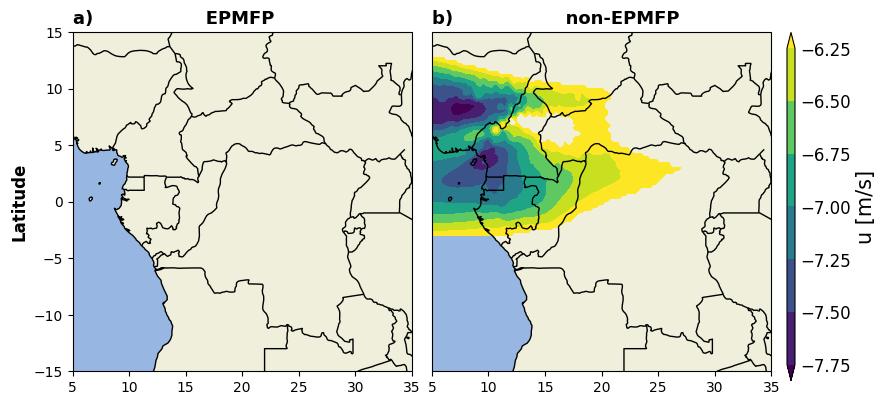

In [155]:
fig = plt.figure(figsize=(8, 6))
projection = ccrs.PlateCarree()

# step=5
# level=np.arange(0, 7.25, 0.25)
cmap='seismic_r'
cmap1='Blues_r'

for i in range(data_pos.shape[0]):
    for j in range(data_pos.shape[1]):
        if data_pos[i, j]>=-6:
            data_pos[i, j]=np.nan  
            
ax = fig.add_subplot(1, 2, 1, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_pos, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
# ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('a)'+' '*18+'EPMFP', fontsize=13, fontweight='bold', loc='left')

for i in range(data_neg.shape[0]):
    for j in range(data_neg.shape[1]):
        if data_neg[i, j]>=-6:
            data_neg[i, j]=np.nan
ax = fig.add_subplot(1, 2, 2, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_neg, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
# ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_title('b)'+' '*18+'non-EPMFP', fontsize=13, fontweight='bold', loc='left')


        
plt.tight_layout(h_pad=0, w_pad=+0.5, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.99, 0.23, 0.01, 0.58])
cbar = plt.colorbar(mymap, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label('u [m/s]', rotation=90, fontsize=15)
cbar.ax.tick_params(labelsize=12, length=0)

plt.savefig('../Figure/Figure99.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure99.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

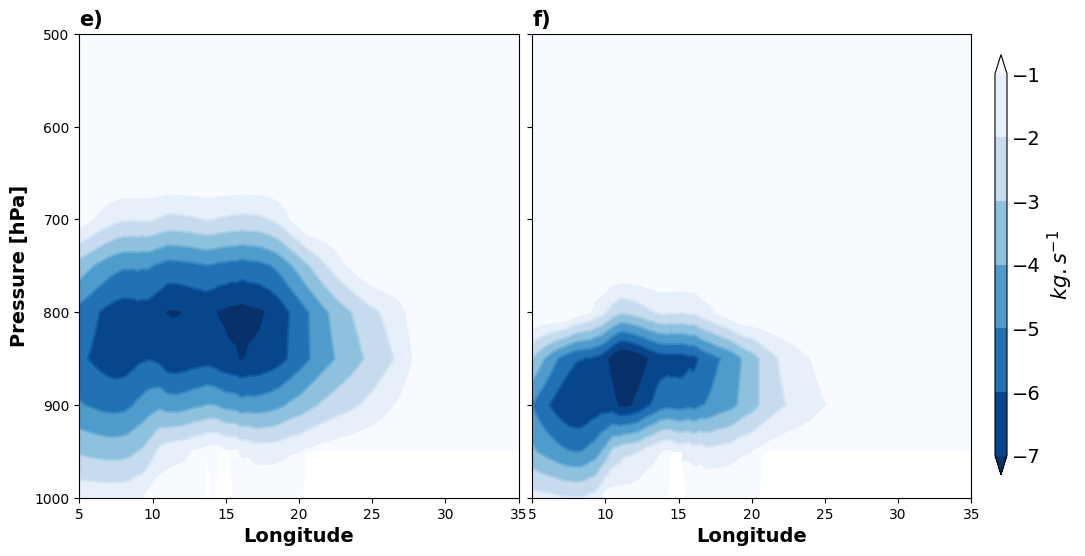

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=False, facecolor='w', edgecolor='k')

cmap='Blues_r'
cmap1='seismic'
level=np.arange(-16, 17, 2)

df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

###########################

data=xr.open_dataset('stream_func_eqq.nc')
data_pos=data.where(data.time.isin(df_region), drop=True)
data_neg=data.where(data.time.isin(df_region_neg), drop=True)

data_pos=data_pos.siz.mean(axis=0)
data_neg=data_neg.siz.mean(axis=0)

for i in range(data_pos.shape[0]):
    for j in range(data_pos.shape[1]):
        if data_pos[i, j]>=0:
            data_pos[i, j]=0
        if data_neg[i, j]>=0:
            data_neg[i, j]=0
psi_z=data_pos.mean(axis=1)
psi_z=psi_z.sum().values.round(2)

psi_z1=data_neg.mean(axis=1)
psi_z1=psi_z1.sum().values.round(2)

#print(f"The intensity of the congo basin cell for EPMFP is {psi_z}, and the one of non-EPMFP is {psi_z1}")

cont = ax[0].contour(data.lon, data.lev,  data_pos, cmap=cmap, extend='both')
cont = ax[0].contourf(data.lon, data.lev,  data_pos, cmap=cmap, extend='both')
ax[0].set_ylim(1000, 500)
ax[0].set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Pressure [hPa]', fontsize=14, fontweight='bold')
ax[0].set_title('e)', fontsize=15, fontweight='bold', loc='left')

cont = ax[1].contour(data.lon, data.lev,  data_neg, cmap=cmap, extend='both')
cont = ax[1].contourf(data.lon, data.lev,  data_neg, cmap=cmap, extend='both')
ax[1].set_ylim(1000, 500)
ax[1].set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax[1].set_title('f)', fontsize=15, fontweight='bold', loc='left')

##########################
plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([1, 0.20, 0.012, 0.70])
cbar = plt.colorbar(cont, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r"$kg.s^{-1}$", rotation=90, fontsize=15)
cbar.ax.tick_params(labelsize=14, length=0)


plt.savefig('../Figure/Figure98.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure98.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [140]:
psi_z

-40.29

In [141]:
psi_z1

-9.21

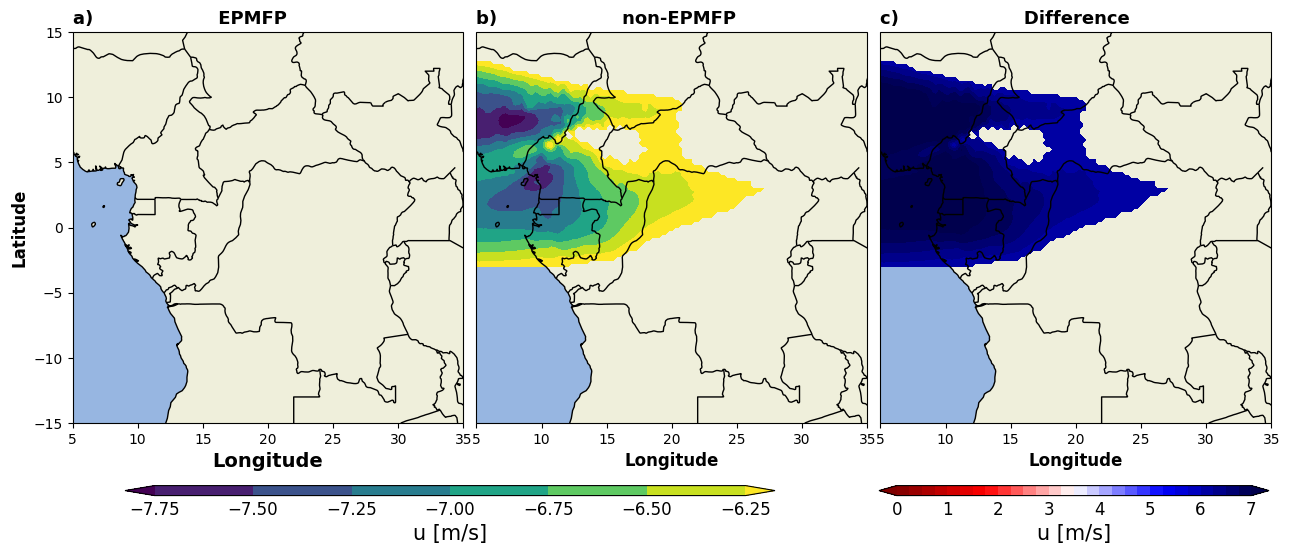

In [11]:
fig = plt.figure(figsize=(13, 10))
projection = ccrs.PlateCarree()

step=5
level=np.arange(0, 7.25, 0.25)
cmap='seismic_r'

for i in range(data_pos.shape[0]):
    for j in range(data_pos.shape[1]):
        if data_pos[i, j]>=-6:
            data_pos[i, j]=np.nan  
            
ax = fig.add_subplot(1, 3, 1, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_pos, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax.set_yticks(np.arange(-15, 16, 5), [str(x) for x in np.arange(-15, 16, 5)])
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('a)'+' '*20+'EPMFP', fontsize=13, fontweight='bold', loc='left')

for i in range(data_neg.shape[0]):
    for j in range(data_neg.shape[1]):
        if data_neg[i, j]>=-6:
            data_neg[i, j]=np.nan
ax = fig.add_subplot(1, 3, 2, projection=projection)
mymap = ax.contourf(data.lon, data.lat,  data_neg, extend='both')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_title('b)'+' '*20+'non-EPMFP', fontsize=13, fontweight='bold', loc='left')


delta=data_pos-data_neg
for i in range(delta.shape[0]):
    for j in range(delta.shape[1]):
        if np.isnan(delta[i, j]):
            delta[i, j]=-data_neg[i, j]
            
ax = fig.add_subplot(1, 3, 3, projection=projection)
mymap1 = ax.contourf(data.lon, data.lat,  delta, extend='both', cmap=cmap, levels=level)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(5, 36, 5), [str(x) for x in np.arange(5, 36, 5)])
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_title('c)'+' '*20+'Difference', fontsize=13, fontweight='bold', loc='left')

# ax.set_title(lab[k], fontsize=14, fontweight='bold', loc='left')
# q = ax.quiver(df1.longitude[::step], df1.latitude[::step], (iqu[::step, ::step]), (iqv[::step, ::step]), 
#                   pivot='mid', units='width', width=0.0025, scale=400)  

        
plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([0.1, 0.26, 0.5, 0.01])
cbar = plt.colorbar(mymap, orientation='horizontal', cax=cbaxes, pad=0, extend='both')
cbar.set_label('u [m/s]', rotation=0, fontsize=15)
cbar.ax.tick_params(labelsize=12, length=0)

cbaxes = fig.add_axes([0.68, 0.26, 0.3, 0.01])
cbar = plt.colorbar(mymap1, orientation='horizontal', cax=cbaxes, pad=0, extend='both')
cbar.set_label('u [m/s]', rotation=0, fontsize=15)
cbar.ax.tick_params(labelsize=12, length=0)
cbar.set_ticks(np.arange(0, 8, 1))
cbar.set_ticklabels([str(x) for x in np.arange(0, 8, 1)])

# plt.savefig('../Figure/Figure8.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
# plt.savefig('../Figure/Figure8.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

/tmp/ipykernel_19584/2544909663.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])


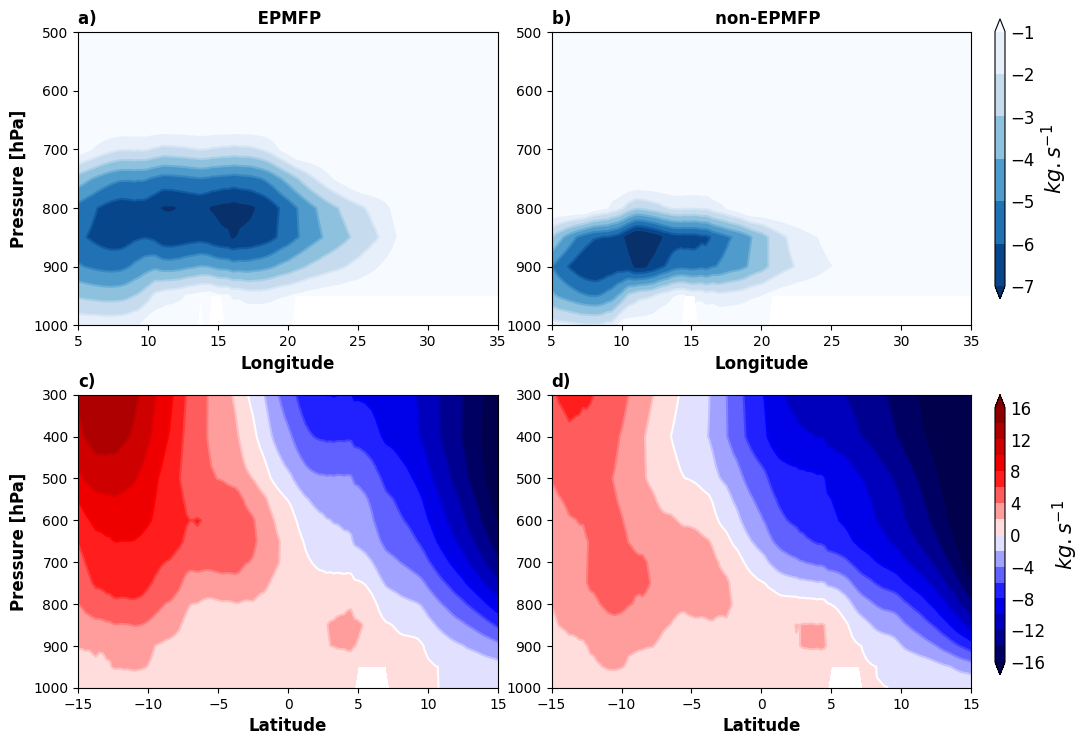

In [12]:
past_year=np.arange(1984, 2002)
present_year=np.arange(2002, 2024)

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharey=False, sharex=False, facecolor='w', edgecolor='k')

cmap='Blues_r'
cmap1='seismic'
level=np.arange(-16, 17, 2)

df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

###########################

data=xr.open_dataset('stream_func_eqq.nc')
data_pos=data.where(data.time.isin(df_region), drop=True)
data_neg=data.where(data.time.isin(df_region_neg), drop=True)

data_pr=data_pos.where(data_pos.time.dt.year.isin([present_year]), drop=True)
data_pa=data_pos.where(data_pos.time.dt.year.isin([past_year]), drop=True)

data_pos=data_pos.siz.mean(axis=0)
data_neg=data_neg.siz.mean(axis=0)

data_pr=data_pr.siz.mean(axis=0)
data_pa=data_pa.siz.mean(axis=0)

for i in range(data_pos.shape[0]):
    for j in range(data_pos.shape[1]):
        if data_pos[i, j]>=0:
            data_pos[i, j]=0
        if data_neg[i, j]>=0:
            data_neg[i, j]=0
psi_z=data_pos.mean(axis=1)
psi_z=psi_z.sum().values.round(2)

psi_z1=data_neg.mean(axis=1)
psi_z1=psi_z1.sum().values.round(2)

#print(f"The intensity of the congo basin cell for EPMFP is {psi_z}, and the one of non-EPMFP is {psi_z1}")

for i in range(data_pr.shape[0]):
    for j in range(data_pr.shape[1]):
        if data_pr[i, j]>=0:
            data_pr[i, j]=0
        if data_pa[i, j]>=0:
            data_pa[i, j]=0

diff_pos=data_pr-data_pa

cont = ax[0, 0].contour(data.lon, data.lev,  data_pos, cmap=cmap, extend='both')
cont = ax[0, 0].contourf(data.lon, data.lev,  data_pos, cmap=cmap, extend='both')
ax[0, 0].set_ylim(1000, 500)
ax[0, 0].set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax[0, 0].set_title('a)'+' '*28 + 'EPMFP', fontsize=12, fontweight='bold', loc='left')
#ax[0, 0].text(12, 550, r"$\Psi_{Z}=$"+f"{psi_z}"+r"$\ \times 10^{11} \  kg.s^{-1}$", fontsize=12)
ax[0, 0].set_ylabel('Pressure [hPa]', fontsize=12, fontweight='bold')
cont = ax[0, 1].contour(data.lon, data.lev,  data_neg, cmap=cmap, extend='both')
cont = ax[0, 1].contourf(data.lon, data.lev,  data_neg, cmap=cmap, extend='both')
ax[0, 1].set_ylim(1000, 500)
ax[0, 1].set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax[0, 1].set_title('b)'+' '*25 + 'non-EPMFP', fontsize=12, fontweight='bold', loc='left')
#ax[0, 1].text(12, 550, r"$\Psi_{Z}=$"+f"{psi_z1}"+r"$\ \times 10^{11} \  kg.s^{-1}$", fontsize=12)

##########################

data=xr.open_dataset('stream_func_m_eqq1.nc')
data_pos=data.where(data.time.isin(df_region), drop=True)
data_neg=data.where(data.time.isin(df_region_neg), drop=True)

data_pr=data_pos.where(data_pos.time.dt.year.isin([present_year]), drop=True)
data_pa=data_pos.where(data_pos.time.dt.year.isin([past_year]), drop=True)

data_pos=data_pos.siz.mean(axis=0)
data_neg=data_neg.siz.mean(axis=0)

data_pr=data_pr.siz.mean(axis=0)
data_pa=data_pa.siz.mean(axis=0)

cont1 = ax[1, 0].contour(data.lat, data.lev,  data_pos, cmap=cmap1, levels=level, extend='both')
cont1 = ax[1, 0].contourf(data.lat, data.lev,  data_pos, cmap=cmap1, levels=level, extend='both')
ax[1, 0].set_ylim(1000, 300)
ax[1, 0].set_xlabel('Latitude', fontsize=12, fontweight='bold')
ax[1, 0].set_ylabel('Pressure [hPa]', fontsize=12, fontweight='bold')
ax[1, 0].set_title('c)', fontsize=12, fontweight='bold', loc='left')
cont1 = ax[1, 1].contour(data.lat, data.lev,  data_neg, cmap=cmap1, levels=level, extend='both')
cont1 = ax[1, 1].contourf(data.lat, data.lev,  data_neg, cmap=cmap1, levels=level, extend='both')
ax[1, 1].set_ylim(1000, 300)
ax[1, 1].set_xlabel('Latitude', fontsize=12, fontweight='bold')
ax[1, 1].set_title('d)', fontsize=12, fontweight='bold', loc='left')

plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([1, 0.62, 0.01, 0.35])
cbar = plt.colorbar(cont, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r"$kg.s^{-1}$", rotation=90, fontsize=15)
cbar.ax.tick_params(labelsize=12, length=0)

plt.tight_layout(h_pad=0, w_pad=0, rect=[0, 0.056, 1, 1])
cbaxes = fig.add_axes([1, 0.15, 0.01, 0.35])
cbar = plt.colorbar(cont1, orientation='vertical', cax=cbaxes, pad=0, extend='both')
cbar.set_label(r"$kg.s^{-1}$", rotation=90, fontsize=15)
cbar.ax.tick_params(labelsize=12, length=0)

plt.savefig('../Figure/Figure9.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure9.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [11]:
df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==0]
df_region=np.array(pd.to_datetime(df_pos['date']))

i=0
j=1363
for k in range(10):
    df_region1=df_region[i:j]

    data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
    dff=data.where(data.time.isin([df_region1]), drop=True)
    dff.to_netcdf(f'data_neg/NON-EPMFP_days_quv_{k}.nc')

    data=xr.open_dataset('CA_1984-2023_daily_sp.nc')
    dff=data.where(data.time.isin([df_region1]), drop=True)
    dff.to_netcdf(f'data_neg/NON-EPMFP_days_sp_{k}.nc')

    print(k ,i, j)
    i=j
    j=j+1363
    if k==8:
        j=j-402

/tmp/ipykernel_42420/2306589853.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=+0.7, w_pad=+0.7, rect=[0, 0.056, 1, 1])


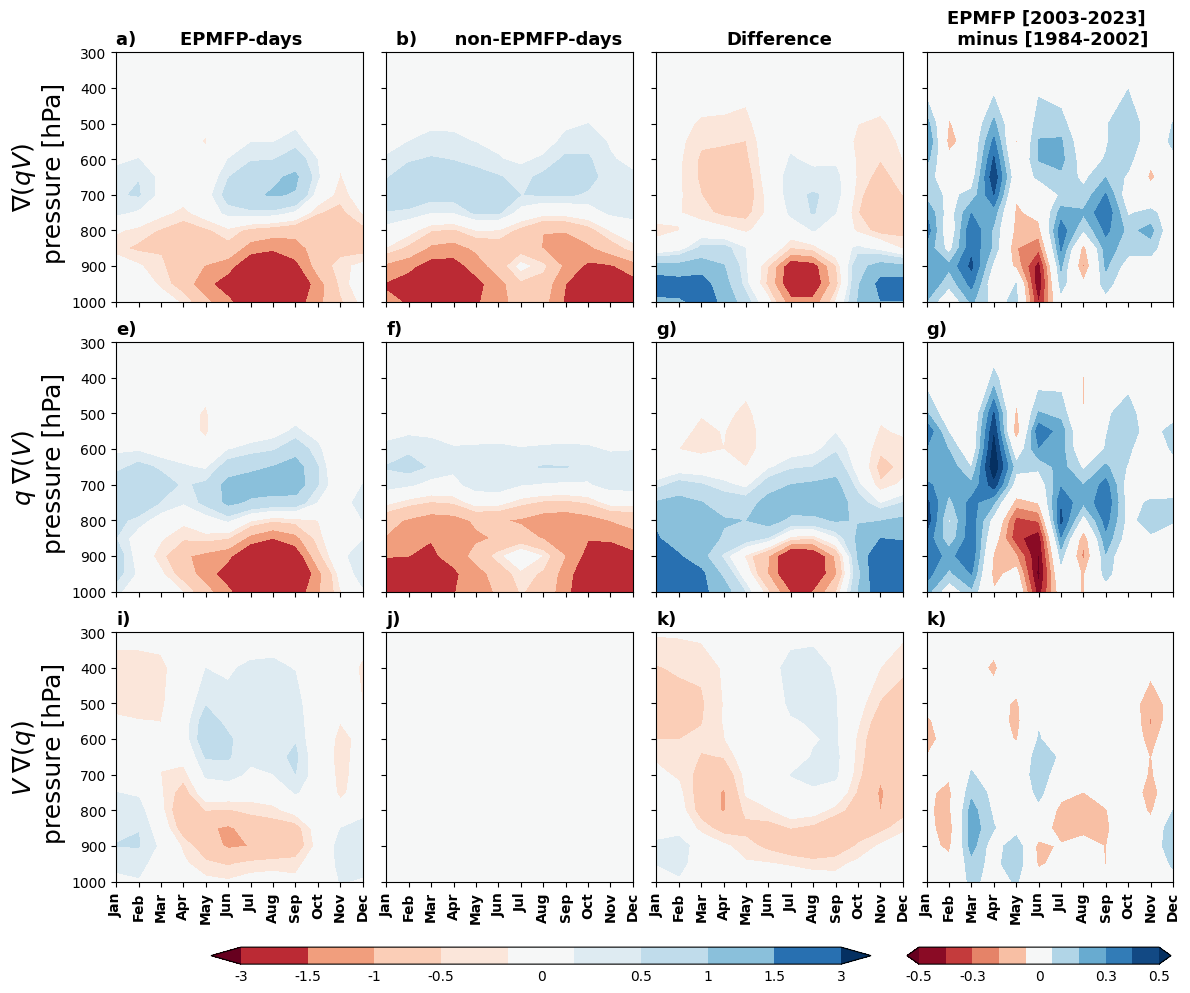

In [165]:
cmap='RdBu'
level=[-3, -1.5, -1, -0.5, -0.25,  0.25, 0.5, 1, 1.5, 3]
ticks=[-3, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 3]

levell=np.array([-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5])
ticks1=[-0.5, -0.3, 0, 0.3, 0.5]

lab=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(3,4, figsize=(12, 10), sharey=True, sharex=True, facecolor='w', edgecolor='k')
path="/home/owner/Documents/Memorial_Project/Project_2/data/grad/"

past_year=np.arange(1984, 2002)
present_year=np.arange(2002, 2024)

## EPMFP-days

#####

data=xr.open_dataset(path+"grad_qv_epmfp_days_masked.nc")
df=data.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))   
cont = ax[0, 0].contourf(df.month, df.lev, df.grad_qv.T*100000, cmap=cmap, levels=level, extend='both')
ax[0, 0].set_ylim(1000, 300)
ax[0, 0].set_title('a)       EPMFP-days', fontsize=13, fontweight='bold', loc='left')
ax[0, 0].set_ylabel(r'$\nabla (qV)$'+'\n pressure [hPa]', fontsize=18)

data=xr.open_dataset(path+"grad_qv_non-epmfp_days_masked_fldmean.nc")
data=data.mean(dim=['lat', 'lon'])
df1=data.groupby('time.month').mean(dim=('time'))   
cont = ax[0, 1].contourf(df.month, df.lev, df1.grad_qv.T*100000, cmap=cmap, levels=level, extend='both')
ax[0, 1].set_ylim(1000, 300)
ax[0, 1].set_title('b)      non-EPMFP-days', fontsize=13, fontweight='bold', loc='center')
  
cont = ax[0, 2].contourf(df.month, df.lev, (df.grad_qv.T-df1.grad_qv.T)*100000, cmap=cmap, levels=level, extend='both')
ax[0, 2].set_ylim(1000, 300)
ax[0, 2].set_title('Difference', fontsize=13, fontweight='bold', loc='center')

data=xr.open_dataset(path+"grad_qv_epmfp_days_masked.nc")
data_pr=data.where(data.time.dt.year.isin([present_year]), drop=True)
data_pa=data.where(data.time.dt.year.isin([past_year]), drop=True)
df=data_pr.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))
df1=data_pa.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))  
cont1 = ax[0, 3].contourf(df.month, df.lev, (df.grad_qv.T-df1.grad_qv.T)*100000, cmap=cmap, levels=levell, extend='both')
ax[0, 3].set_ylim(1000, 300)
ax[0, 3].set_title('EPMFP [2003-2023] \n minus [1984-2002]', fontsize=13, fontweight='bold', loc='center')

######

data=xr.open_dataset(path+"q_grad_v_epmfp_days_masked.nc")
df=data.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))   
cont = ax[1, 0].contourf(df.month, df.lev, df.q_grad_v.T*100000, cmap=cmap, levels=level, extend='both')
ax[1, 0].set_ylim(1000, 300)
ax[1, 0].set_title('e)', fontsize=13, fontweight='bold', loc='left')
ax[1, 0].set_ylabel(r'$q \; \nabla (V)$'+'\n pressure [hPa]', fontsize=18)

data=xr.open_dataset(path+"q_grad_v_non-epmfp_days_masked_fldmean.nc")
data=data.mean(dim=['lat', 'lon'])
df1=data.groupby('time.month').mean(dim='time')   
cont = ax[1, 1].contourf(df.month, df.lev, df1.q_grad_v.T*100000, cmap=cmap, levels=level, extend='both')
ax[1, 1].set_ylim(1000, 300)
ax[1, 1].set_title('f)', fontsize=13, fontweight='bold', loc='left')

cont = ax[1, 2].contourf(df.month, df.lev, (df.q_grad_v.T-df1.q_grad_v.T)*100000, cmap=cmap, levels=level, extend='both')
ax[1, 2].set_ylim(1000, 300)
ax[1, 2].set_title('g)', fontsize=13, fontweight='bold', loc='left')

data=xr.open_dataset(path+"q_grad_v_epmfp_days_masked.nc")
data_pr=data.where(data.time.dt.year.isin([present_year]), drop=True)
data_pa=data.where(data.time.dt.year.isin([past_year]), drop=True)
df=data_pr.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))
df1=data_pa.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))  
cont1 = ax[1, 3].contourf(df.month, df.lev, (df.q_grad_v.T-df1.q_grad_v.T)*100000, cmap=cmap, levels=levell, extend='both')
ax[1, 3].set_ylim(1000, 300)
ax[1, 3].set_title('g)', fontsize=13, fontweight='bold', loc='left')

######

data=xr.open_dataset(path+"v_grad_q_epmfp_days_masked.nc")
df=data.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))   
cont = ax[3, 1].contourf(df.month, df.lev, df.v_grad_q.T*100000, cmap=cmap, levels=level, extend='both')
ax[2, 0].set_ylim(1000, 300)
ax[2, 0].set_title('i)', fontsize=13, fontweight='bold', loc='left')
ax[2, 0].set_ylabel(r'$V \; \nabla (q)$'+'\n pressure [hPa]', fontsize=18)

data=xr.open_dataset(path+"v_grad_q_non-epmfp_days_masked_fldmean.nc")
data=data.mean(dim=['lat', 'lon'])
df1=data.groupby('time.month').mean(dim='time')   
cont = ax[2, 1].contourf(df.month, df.lev, df1.v_grad_q.T*10000, cmap=cmap, levels=level, extend='both')
ax[2, 1].set_ylim(1000, 300)
ax[2, 1].set_title('j)', fontsize=13, fontweight='bold', loc='left')

cont1 = ax[2, 2].contourf(df.month, df.lev, (df.v_grad_q.T-df1.v_grad_q.T)*100000, cmap=cmap, levels=level, extend='both')
ax[2, 2].set_ylim(1000, 300)
ax[2, 2].set_title('k)', fontsize=13, fontweight='bold', loc='left')

data=xr.open_dataset(path+"v_grad_q_epmfp_days_masked.nc")
data_pr=data.where(data.time.dt.year.isin([present_year]), drop=True)
data_pa=data.where(data.time.dt.year.isin([past_year]), drop=True)
df=data_pr.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))
df1=data_pa.groupby('time.month').mean(dim=(['time', 'lat', 'lon']))  
cont1 = ax[2, 3].contourf(df.month, df.lev, (df.v_grad_q.T-df1.v_grad_q.T)*100000, cmap=cmap, levels=levell, extend='both')
ax[2, 3].set_ylim(1000, 300)
ax[2, 3].set_title('k)', fontsize=13, fontweight='bold', loc='left')


#######



ax[2, 0].set_xticks(np.arange(1, 13), lab, rotation=90, fontweight='bold')
ax[2, 1].set_xticks(np.arange(1, 13), lab, rotation=90, fontweight='bold')
ax[2, 2].set_xticks(np.arange(1, 13), lab, rotation=90, fontweight='bold')
ax[2, 3].set_xticks(np.arange(1, 13), lab, rotation=90, fontweight='bold')

cbaxes = fig.add_axes([0.18, 0.03, 0.55, 0.017])
cbar = plt.colorbar(cont, orientation='horizontal', cax = cbaxes, pad=0)
cbar.ax.tick_params(labelsize=10, length=0)
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(x) for x in ticks])


cbaxes = fig.add_axes([0.76, 0.03, 0.22, 0.017])
cbar = plt.colorbar(cont1, orientation='horizontal', cax = cbaxes, pad=0)
cbar.ax.tick_params(labelsize=10, length=0)
cbar.set_ticks(ticks1)  
cbar.set_ticklabels([str(x) for x in ticks1])

plt.tight_layout(h_pad=+0.7, w_pad=+0.7, rect=[0, 0.056, 1, 1])
plt.savefig('../Figure/Figure10.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure10.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

In [24]:
fig, ax = plt.subplots(4,2, figsize=(14, 10), facecolor='w', edgecolor='k')
path="/home/owner/Documents/Memorial_Project/Project_2/data/grad/"

years = np.arange(1984, 2024)

df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))

df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

###############################
data_pr=xr.open_dataset('CA_1984-2023_daily_pr_masked.nc')
data_pr=data_pr.where(data_pr.time.isin(df_region), drop=True)
data_pr=data_pr.groupby('time.year').mean(dim=(['time', 'latitude', 'longitude']))
data_pr=data_pr.pr.values
##############################
year=[str(k) for k in np.arange(1984, 2024)]
year_time=list(pd.to_datetime(df_pos['date']).dt.year)
data_pr_per_year=np.zeros(len(year))
for i, y in enumerate([int(k) for k in year]):
    data_pr_per_year[i]=year_time.count(y)
#################################

corr1=[]
pval1=[]

corr2=[]
pval2=[]

data=xr.open_dataset(path+"grad_qv_epmfp_days_masked.nc")
data=data.sel(lat=slice(10.1, 9.9), lon=slice(5, 35))
data=data.sel(lev=slice(1000, 299))
data=np.squeeze(data)
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos=data_pos.groupby('time.year').mean(dim=(['time', 'lon']))

qv_pos=data_pos.grad_qv.values
qv_pos=qv_pos*100000

qv_pos=qv_pos.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, qv_pos)
ax[0, 0].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[0, 0].text(0.8, 8, f'slope={slope:.4f}', color='black')
ax[0, 0].text(0.8, 7, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], qv_pos[:-20])
ax[0, 0].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[0, 0].text(10, 8, f'slope={slope:.4f}', color='blue')
ax[0, 0].text(10, 7, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], qv_pos[19:])
ax[0, 0].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[0, 0].set_xlim(-0.5, 39.5)
# ax[0, 0].set_ylim(4.5, 6.5)
# ax[0, 0].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[0, 0].plot(year[:-20], qv_pos[:-20], '-o', color='blue')
ax[0, 0].plot(year[19:], qv_pos[19:], '-o', color='green')
ax[0, 0].text(30, 1, f'slope={slope:.4f}', color='green')
ax[0, 0].text(30, 0, f'p={p_value:.4f}', color='green')
# ax[0, 0].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[0, 0].set_title('a)  Moisture flux convergence')
ax[0, 0].set_xticks('')

r, p = stats.pearsonr(data_pr_per_year, qv_pos)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, qv_pos)
corr2.append(r)
pval2.append(p)
###############################

data=xr.open_dataset('stream_func_eqq.nc')
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos_year=data_pos.groupby("time.year").mean(dim=['time']).siz.values

for k in range(data_pos_year.shape[0]):
    for i in range(data_pos_year.shape[1]):
        for j in range(data_pos_year.shape[2]):
            if data_pos_year[k, i, j]>=0:
                data_pos_year[k, i, j]=0
            if np.isnan(data_pos_year[k, i, j]):
                data_pos_year[k, i, j]=0
                
psi_z=data_pos_year.mean(axis=2)
psi_z=psi_z.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, psi_z)
ax[0, 1].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[0, 1].text(0.8, -58, f'slope={slope:.4f}', color='black')
ax[0, 1].text(0.8, -62, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], psi_z[:-20])
ax[0, 1].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[0, 1].text(15, -58, f'slope={slope:.4f}', color='blue')
ax[0, 1].text(15, -62, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], psi_z[19:])
ax[0, 1].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[0, 1].set_xlim(-0.5, 39.5)
# ax[0, 1].set_ylim(4.5, 6.5)
#ax[0, 1].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[0, 1].plot(year[:-20], psi_z[:-20], '-o', color='blue')
ax[0, 1].plot(year[19:], psi_z[19:], '-o', color='green')
ax[0, 1].text(30, -58, f'slope={slope:.4f}', color='green')
ax[0, 1].text(30, -62, f'p={p_value:.4f}', color='green')
# ax[0, 1].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[0, 1].set_title('b)  Congo Basin Cell')
ax[0, 1].set_xticks('')

r, p = stats.pearsonr(data_pr_per_year, psi_z)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, psi_z)
corr2.append(r)
pval2.append(p)

##########################

data=xr.open_dataset('stream_func_m_eqq1.nc')
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos_year=data_pos.groupby("time.year").mean(dim=['time']).siz.values

for k in range(data_pos_year.shape[0]):
    for i in range(data_pos_year.shape[1]):
        for j in range(datslope, intercept, r_value, p_value, std_err = linregress(data_pr, psi_z)
ax[0, 1].plot(data_pr, slope*data_pr+intercept)
ax[0, 1].scatter(data_pr, psi_z, s=1)a_pos_year.shape[2]):
            if data_pos_year[k, i, j]<0:
                data_pos_year[k, i, j]=0
            if np.isnan(data_pos_year[k, i, j]):
                data_pos_year[k, i, j]=0
                
psi_z=data_pos_year.mean(axis=2)
psi_z=psi_z.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, psi_z)
ax[1, 0].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[1, 0].text(0.8, 20, f'slope={slope:.4f}', color='black')
ax[1, 0].text(0.8, 12, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], psi_z[:-20])
ax[1, 0].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[1, 0].text(0.8, 62, f'slope={slope:.4f}', color='blue')
ax[1, 0].text(0.8, 54, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], psi_z[19:])
ax[1, 0].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[1, 0].set_xlim(-0.5, 39.5)
# ax[1,  0].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[1, 0].plot(year[:-20], psi_z[:-20], '-o', color='blue')
ax[1, 0].plot(year[19:], psi_z[19:], '-o', color='green')
ax[1, 0].text(25, 62, f'slope={slope:.4f}', color='green')
ax[1, 0].text(25, 54, f'p={p_value:.4f}', color='green')
# ax[1, 0].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[1, 0].set_title('c)  Hadley cell ascending branch')
ax[1, 0].set_xticks('')

r, p = stats.pearsonr(data_pr_per_year, psi_z)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, psi_z)
corr2.append(r)
pval2.append(p)

###################

data=xr.open_dataset('stream_func_m_eqq1.nc')
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos_year=data_pos.groupby("time.year").mean(dim=['time']).siz.values

for k in range(data_pos_year.shape[0]):
    for i in range(data_pos_year.shape[1]):
        for j in range(data_pos_year.shape[2]):
            if data_pos_year[k, i, j]>0:
                data_pos_year[k, i, j]=0
            if np.isnan(data_pos_year[k, i, j]):
                data_pos_year[k, i, j]=0
                
psi_z=data_pos_year.mean(axis=2)
psi_z=psi_z.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, psi_z)
ax[1, 1].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[1, 1].text(0.8, -58, f'slope={slope:.4f}', color='black')
ax[1, 1].text(0.8, -64, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], psi_z[:-20])
ax[1, 1].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[1, 1].text(14, -58, f'slope={slope:.4f}', color='blue')
ax[1, 1].text(14, -64, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], psi_z[19:])
ax[1, 1].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[1, 1].set_xlim(-0.5, 39.5)
# ax[1, 1].set_ylim(4.5, 6.5)
# ax[1, 1].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[1, 1].plot(year[:-20], psi_z[:-20], '-o', color='blue')
ax[1, 1].plot(year[19:], psi_z[19:], '-o', color='green')
ax[1, 1].text(28, -10, f'slope={slope:.4f}', color='green')
ax[1, 1].text(28, -15, f'p={p_value:.4f}', color='green')
# ax[1, 1].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[1, 1].set_title('d)  Hadley cell descending branch')
ax[1, 1].set_xticks('')

r, p = stats.pearsonr(data_pr_per_year, psi_z)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, psi_z)
corr2.append(r)
pval2.append(p)


#######################

data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lat=slice(15, -15), lon=slice(9.8, 10.1))
data=data.sel(lev=slice(1000, 799))
data=np.squeeze(data)
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos=data_pos.groupby('time.year').mean(dim=(['time', 'lat']))

q_pos=data_pos.q.values
q_pos=q_pos*1000
u_pos=data_pos.u.values

qu_pos= q_pos*u_pos
qu_pos=qu_pos.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, qu_pos)
ax[2, 0].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[2, 0].text(1, 20, f'slope={slope:.4f}', color='black')
ax[2, 0].text(1, 14, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], qu_pos[:-20])
ax[2, 0].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[2, 0].text(15, 20, f'slope={slope:.4f}', color='blue')
ax[2, 0].text(15, 14, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], qu_pos[19:])
ax[2, 0].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[2, 0].set_xlim(-0.5, 39.5)
# ax[2, 0].set_ylim(4.5, 6.5)
# ax[2, 0].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[2, 0].plot(year[:-20], qu_pos[:-20], '-o', color='blue')
ax[2, 0].plot(year[19:], qu_pos[19:], '-o', color='green')
ax[2, 0].text(25, 66, f'slope={slope:.4f}', color='green')
ax[2, 0].text(25, 58, f'p={p_value:.4f}', color='green')
# ax[2, 0].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[2, 0].set_title('e)  Zonal moisture transport [1000-800hPa] at 10E')
ax[2, 0].set_xticks('')

r, p = stats.pearsonr(data_pr_per_year, qu_pos)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, qu_pos)
corr2.append(r)
pval2.append(p)


##############

data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lat=slice(15, -15), lon=slice(9.8, 10.1))
data=data.sel(lev=slice(799, 499))
data=np.squeeze(data)
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos=data_pos.groupby('time.year').mean(dim=(['time', 'lat']))

q_pos=data_pos.q.values
q_pos=q_pos*1000
u_pos=data_pos.u.values

qu_pos= q_pos*u_pos
qu_pos=qu_pos.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, qu_pos)
ax[2, 1].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[2, 1].text(0.8, -118, f'slope={slope:.4f}', color='black')
ax[2, 1].text(0.8, -124, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], qu_pos[:-20])
ax[2, 1].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[2, 1].text(15, -66, f'slope={slope:.4f}', color='blue')
ax[2, 1].text(15, -72, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], qu_pos[19:])
ax[2, 1].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[2, 1].set_xlim(-0.5, 39.5)
# ax[2, 1].set_ylim(4.5, 6.5)
#ax[2, 1].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[2, 1].plot(year[:-20], qu_pos[:-20], '-o', color='blue')
ax[2, 1].plot(year[19:], qu_pos[19:], '-o', color='green')
ax[2, 1].text(25, -66, f'slope={slope:.4f}', color='green')
ax[2, 1].text(25, -72, f'p={p_value:.4f}', color='green')
# ax[2, 1].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[2, 1].set_title('f)  Zonal moisture transport [750-500hPa] at 10E')
ax[2, 1].set_xticks('')


r, p = stats.pearsonr(data_pr_per_year, qu_pos)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, qu_pos)
corr2.append(r)
pval2.append(p)

###########################

data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lat=slice(10.1, 9.9), lon=slice(5, 35))
data=data.sel(lev=slice(1000, 799))
data=np.squeeze(data)
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos=data_pos.groupby('time.year').mean(dim=(['time', 'lon']))

q_pos=data_pos.q.values
q_pos=q_pos*1000
v_pos=data_pos.v.values

qv_pos= q_pos*v_pos
qv_pos=qv_pos.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, qv_pos)
ax[3, 0].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[3, 0].text(0.8, 54, f'slope={slope:.4f}', color='black')
ax[3, 0].text(0.8, 44, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], qv_pos[:-20])
ax[3, 0].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[3, 0].text(20, 54, f'slope={slope:.4f}', color='blue')
ax[3, 0].text(20, 44, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], qv_pos[19:])
ax[3, 0].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[3, 0].set_xlim(-0.5, 39.5)
# ax[3, 0].set_ylim(4.5, 6.5)
# ax[3, 0].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[3, 0].plot(year[:-20], qv_pos[:-20], '-o', color='blue')
ax[3, 0].plot(year[19:], qv_pos[19:], '-o', color='green')
ax[3, 0].text(30, 54, f'slope={slope:.4f}', color='green')
ax[3, 0].text(30, 44, f'p={p_value:.4f}', color='green')
# ax[3, 0].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[3, 0].set_title('g)  Meridional moisture transport [1000-800hPa] at 10N')
ax[3, 0].set_xticks(np.arange(0, 40), year, rotation=90, fontsize=10)


r, p = stats.pearsonr(data_pr_per_year, qv_pos)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, qv_pos)
corr2.append(r)
pval2.append(p)

#################################

data=xr.open_dataset('CA_1984-2023_daily_quv.nc')
data=data.sel(lat=slice(10.1, 9.9), lon=slice(5, 35))
data=data.sel(lev=slice(799, 499))
data=np.squeeze(data)
data_pos=data.where(data.time.isin(df_region), drop=True)
data_pos=data_pos.groupby('time.year').mean(dim=(['time', 'lon']))

q_pos=data_pos.q.values
q_pos=q_pos*1000
v_pos=data_pos.v.values
ax[2, 0]
qv_pos= q_pos*v_pos
qv_pos=qv_pos.sum(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(years, qv_pos)
ax[3, 1].plot(slope*years+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='black')
ax[3, 1].text(0.8, -45, f'slope={slope:.4f}', color='black')
ax[3, 1].text(0.8, -50, f'p={p_value:.4f}', color='black')

slope, intercept, r_value, p_value, std_err = linregress(years[:-20], qv_pos[:-20])
ax[3, 1].plot(year[:-20], slope*years[:-20]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='blue')
ax[3, 1].text(15, -45, f'slope={slope:.4f}', color='blue')
ax[3, 1].text(15, -50, f'p={p_value:.4f}', color='blue')

slope, intercept, r_value, p_value, std_err = linregress(years[19:], qv_pos[19:])
ax[3, 1].plot(year[19:], slope*years[19:]+intercept, '--', label=f'slope={slope:.3f} p={p_value:.3f}', color='green')
ax[3, 1].set_xlim(-0.5, 39.5)
# ax[3, 1].set_ylim(4.5, 6.5)
# ax[3, 1].set_ylabel('Rainfall spatial mean \n [mm/day]')
ax[3, 1].plot(year[:-20], qv_pos[:-20], '-o', color='blue')
ax[3, 1].plot(year[19:], qv_pos[19:], '-o', color='green')
ax[3, 1].text(25, -45, f'slope={slope:.4f}', color='green')
ax[3, 1].text(25, -50, f'p={p_value:.4f}', color='green')
# ax[3, 1].text(0.5, 6.25, 'b', bbox=dict(facecolor='white', alpha=1), fontweight='bold', horizontalalignment='center',verticalalignment='bottom', color='black', fontsize=12)
ax[3, 1].set_title('h)  Meridional moisture transport [750-500hPa] at 10N')
#ax[3, 1].set_xticks('')

r, p = stats.pearsonr(data_pr_per_year, qv_pos)
corr1.append(r)
pval1.append(p)

r, p = stats.pearsonr(data_pr, qv_pos)
corr2.append(r)
pval2.append(p)

#################################
ax[3, 1].set_xticks(np.arange(0, 40), year, rotation=90, fontsize=10)
plt.tight_layout(h_pad=+0.7, w_pad=+0.7, rect=[0, 0.056, 1, 1])


plt.savefig('../Figure/Figure11.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure11.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1961253318.py, line 130)

In [130]:
early_year=np.arange(1984, 2003)
late_year=np.arange(2003, 2024)

data=xr.open_dataset('CA_1984-2023_daily_pr_masked.nc')
data_early=data.where(data.time.dt.year.isin(early_year), drop=True)
data_late=data.where(data.time.dt.year.isin(late_year), drop=True)

df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))
df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))


# Climatology
data_0=data.where(data.time.isin(df_region_neg), drop=True).mean(dim=['time', 'latitude', 'longitude']).pr.values
data_1=data.where(data.time.isin(df_region), drop=True).mean(dim=['time', 'latitude', 'longitude']).pr.values
f0=len(df_region_neg)
f1=len(df_region)
f00=f0
f11=f1

# Late
data_late0=data_late.where(data_late.time.isin(df_region_neg), drop=True)
data_late1=data_late.where(data_late.time.isin(df_region), drop=True)
f0_late=len(data_late0.time.values)
f1_late=len(data_late1.time.values)
f00_late=f0_late
f00_late_prime=f00_late-f00
f11_late=f1_late
f11_late_prime=f11_late-f11
data_late00=data_late0.mean(dim=['time', 'latitude', 'longitude']).pr.values
data_late11=data_late1.mean(dim=['time', 'latitude', 'longitude']).pr.values

# Early
data_early0=data_early.where(data_early.time.isin(df_region_neg), drop=True)
data_early1=data_early.where(data_early.time.isin(df_region), drop=True)
f0_early=len(data_early0.time.values)
f1_early=len(data_early1.time.values)
f00_early=f0_early
f00_early_prime=f00_early-f00
f11_early=f1_early
f11_early_prime=f11_early-f11
data_early00=data_early0.mean(dim=['time', 'latitude', 'longitude']).pr.values
data_early11=data_early1.mean(dim=['time', 'latitude', 'longitude']).pr.values

# All
dyn_all=data_0*(f00_late_prime-f00_early_prime)+data_1*(f11_late_prime-f11_early_prime)
therm_all=f00*(data_late00-data_early00)+f11*(data_late11-data_early11)
inter_all=((f00_late_prime*(data_late00-data_0))-(f00_early_prime*(data_early00-data_0)))+((f11_late_prime*(data_late11-data_1))-(f11_early_prime*(data_early11-data_1)))

# EPMFP
dyn_epmfp=data_1*(f11_late-f11_early)
therm_epmfp=f11*(data_late11-data_early11)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


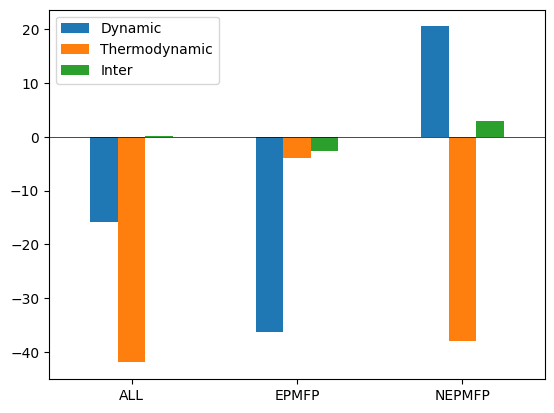

In [44]:
early_year=np.arange(1984, 2003)
late_year=np.arange(2003, 2024)

data=xr.open_dataset('CA_1984-2023_daily_pr_masked.nc')
data_early=data.where(data.time.dt.year.isin(early_year), drop=True)
data_late=data.where(data.time.dt.year.isin(late_year), drop=True)

df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))
df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

#Fequency
f0=len(df_region_neg)*100/(len(df_region_neg)+len(df_region))
f1=len(df_region)*100/(len(df_region_neg)+len(df_region))

f0_l=data_late.where(data_late.time.isin(df_region_neg), drop=True)
f0_e=data_early.where(data_early.time.isin(df_region_neg), drop=True)

f0l=len(f0_l.time)*100/(len(f0_l.time)+len(f0_e.time))
f0e=len(f0_e.time)*100/(len(f0_l.time)+len(f0_e.time))

f1_l=data_late.where(data_late.time.isin(df_region), drop=True)
f1_e=data_early.where(data_early.time.isin(df_region), drop=True)
f1l=len(f1_l.time)*100/(len(f1_l.time)+len(f1_e.time))
f1e=len(f1_e.time)*100/(len(f1_l.time)+len(f1_e.time))

D0l=f0l-f0
D0e=f0e-f0

D1l=f1l-f1
D1e=f1e-f1


#precipitation Values
p0=data.where(data.time.isin(df_region_neg), drop=True).mean(dim=['latitude', 'longitude'])
p1=data.where(data.time.isin(df_region), drop=True).mean(dim=['latitude', 'longitude'])

p0l=p0.where(p0.time.dt.year.isin(late_year), drop=True)
p0e=p0.where(p0.time.dt.year.isin(early_year), drop=True)

p1l=p1.where(p1.time.dt.year.isin(late_year), drop=True)
p1e=p1.where(p1.time.dt.year.isin(early_year), drop=True)

D0l_prime=p0l.pr.mean()-p0.pr.mean()
D0e_prime=p0e.pr.mean()-p0.pr.mean()

D1l_prime=p0l.pr.mean()-p0.pr.mean()
D1e_prime=p0e.pr.mean()-p0.pr.mean()


Dyn_all=p0.pr.mean()*(D0l-D0e)+p1.pr.mean()*(D1l-D1e)
Thermo_all=f0*(D0l_prime-D0e_prime)+f1*(D1l_prime-D1e_prime)
In_all=(D0l_prime-D0e_prime)*(D0l-D0e)+(D1l_prime-D1e_prime)*(D1l-D1e)


Dyn_e=p1.pr.mean()*(D1l-D1e)
Thermo_e=f1*(p1l.pr.mean()-p1e.pr.mean())
In_e=(D0l_prime-D0e_prime)*(D0l-D0e)

Dyn_ne=p0.pr.mean()*(D0l-D0e)
Thermo_ne=f0*(p0l.pr.mean()-p0e.pr.mean())
In_ne=(D1l_prime-D1e_prime)*(D1l-D1e)


All = [float(Dyn_all), float(Dyn_e), float(Dyn_ne)]
EPMFC = [float(Thermo_all), float(Thermo_e), float(Thermo_ne)]
NEPMFC = [float(In_all), float(In_e), float(In_ne)]
index = ['ALL', 'EPMFP', 'NEPMFP']
df = pd.DataFrame({'Dynamic': All,
                   'Thermodynamic': EPMFC, 
                   'Inter': NEPMFC}, index=index)
ax = df.plot.bar(rot=0)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.savefig('../Figure/Figure12.eps', bbox_inches='tight', pad_inches=0.1, format='eps', dpi=600)
plt.savefig('../Figure/Figure12.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 

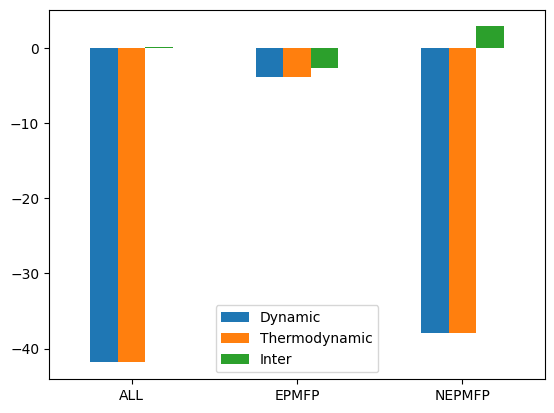

In [20]:
early_year=np.arange(1984, 2003)
late_year=np.arange(2003, 2024)

data=xr.open_dataset('CA_1984-2023_daily_pr_masked.nc')
data_early=data.where(data.time.dt.year.isin(early_year), drop=True)
data_late=data.where(data.time.dt.year.isin(late_year), drop=True)

df=pd.read_csv('model_predictions.csv')
df_pos=df[df['predicted_class']==1]
df_region=np.array(pd.to_datetime(df_pos['date']))
df_neg=df[df['predicted_class']==0]
df_region_neg=np.array(pd.to_datetime(df_neg['date']))

#Fequency
f0=len(df_region_neg)*100/(len(df_region_neg)+len(df_region))
f1=len(df_region)*100/(len(df_region_neg)+len(df_region))

f0_l=data_late.where(data_late.time.isin(df_region_neg), drop=True)
f0_e=data_early.where(data_early.time.isin(df_region_neg), drop=True)

f0l=len(f0_l.time)*100/(len(f0_l.time)+len(f0_e.time))
f0e=len(f0_e.time)*100/(len(f0_l.time)+len(f0_e.time))

f1_l=data_late.where(data_late.time.isin(df_region), drop=True)
f1_e=data_early.where(data_early.time.isin(df_region), drop=True)
f1l=len(f1_l.time)*100/(len(f1_l.time)+len(f1_e.time))
f1e=len(f1_e.time)*100/(len(f1_l.time)+len(f1_e.time))

D0l=f0l-f0
D0e=f0e-f0

D1l=f1l-f1
D1e=f1e-f1


#precipitation Values
p0=data.where(data.time.isin(df_region_neg), drop=True).mean(dim=['latitude', 'longitude'])
p1=data.where(data.time.isin(df_region), drop=True).mean(dim=['latitude', 'longitude'])

p0l=p0.where(p0.time.dt.year.isin(late_year), drop=True)
p0e=p0.where(p0.time.dt.year.isin(early_year), drop=True)

p1l=p1.where(p1.time.dt.year.isin(late_year), drop=True)
p1e=p1.where(p1.time.dt.year.isin(early_year), drop=True)

D0l_prime=p0l.pr.mean()-p0.pr.mean()
D0e_prime=p0e.pr.mean()-p0.pr.mean()

D1l_prime=p0l.pr.mean()-p0.pr.mean()
D1e_prime=p0e.pr.mean()-p0.pr.mean()

a0=f0*p0
a1=f1*p1
D0=float(a0.where(a0.time.dt.year.isin(late_year), drop=True).pr.mean()-a0.where(a0.time.dt.year.isin(early_year), drop=True).pr.mean())
D1=float(a1.where(a1.time.dt.year.isin(late_year), drop=True).pr.mean()-a1.where(a1.time.dt.year.isin(early_year), drop=True).pr.mean())

Dyn_all=D0+D1
Thermo_all=f0*(p0l.pr.mean()-p0e.pr.mean())+f1*(p1l.pr.mean()-p1e.pr.mean())
In_all=(f0l-f0e)*(p0l.pr.mean()-p0e.pr.mean())+(f1l-f1e)*(p1l.pr.mean()-p1e.pr.mean())


Dyn_e=D1
Thermo_e=f1*(p1l.pr.mean()-p1e.pr.mean())
In_e=(D0l_prime-D0e_prime)*(D0l-D0e)

Dyn_ne=D0
Thermo_ne=f0*(p0l.pr.mean()-p0e.pr.mean())
In_ne=(D1l_prime-D1e_prime)*(D1l-D1e)


All = [float(Dyn_all), float(Dyn_e), float(Dyn_ne)]
EPMFC = [float(Thermo_all), float(Thermo_e), float(Thermo_ne)]
NEPMFC = [float(In_all), float(In_e), float(In_ne)]
index = ['ALL', 'EPMFP', 'NEPMFP']
df = pd.DataFrame({'Dynamic': All,
                   'Thermodynamic': EPMFC, 
                   'Inter': NEPMFC}, index=index)
ax = df.plot.bar(rot=0)

In [11]:
a0=f0*p0
a1=f1*p1

In [14]:
D0=a0.where(a0.time.dt.year.isin(late_year), drop=True).pr.mean()

In [26]:
D1

-3.8710250854492188

In [18]:
D0=float(a0.where(a0.time.dt.year.isin(late_year), drop=True).pr.mean()-a0.where(a0.time.dt.year.isin(early_year), drop=True).pr.mean())

In [24]:
Thermo_all

<xarray.DataArray 'pr' ()> Size: 8B
array(-41.83555319)

In [11]:
data=pd.read_csv("model_predictions.csv")

In [18]:
false_psitif=data[(data['predicted_class']==0) & (data['true_y']==1)]

In [19]:
(len(false_psitif)*100)/len(data)

0.43121149897330596

In [20]:
false_psitif

Unnamed: 0        date    prob_0    prob_1  predicted_class    set  \
82             82  1984-03-23  0.737273  0.262727                0   test   
475           475  1985-04-20  0.859397  0.140603                0   test   
574           574  1985-07-28  0.511529  0.488471                0  train   
580           580  1985-08-03  0.578843  0.421157                0   test   
827           827  1986-04-07  0.741907  0.258093                0   test   
...           ...         ...       ...       ...              ...    ...   
13865       13865  2021-12-17  0.852575  0.147425                0   test   
13883       13883  2022-01-04  0.744376  0.255624                0   test   
14465       14465  2023-08-09  0.655735  0.344265                0   test   
14575       14575  2023-11-27  0.837355  0.162645                0   test   
14579       14579  2023-12-01  0.880640  0.119360                0   test   

       true_y  
82          1  
475         1  
574         1  
580         1  
827         1  
...       ...  
13865       1  
13883       1  
14465       1  
14575       1  
14579       1  

[63 rows x 7 columns]

In [23]:
data[data['true_y']==1]

Unnamed: 0        date    prob_0    prob_1  predicted_class    set  \
5               5  1984-01-06  0.051278  0.948722                1  train   
6               6  1984-01-07  0.477939  0.522061                1   test   
14             14  1984-01-15  0.267341  0.732659                1  train   
69             69  1984-03-10  0.274497  0.725503                1  train   
82             82  1984-03-23  0.737273  0.262727                0   test   
...           ...         ...       ...       ...              ...    ...   
14579       14579  2023-12-01  0.880640  0.119360                0   test   
14581       14581  2023-12-03  0.104538  0.895462                1  train   
14589       14589  2023-12-11  0.144278  0.855722                1  train   
14604       14604  2023-12-26  0.000323  0.999677                1   test   
14605       14605  2023-12-27  0.107737  0.892263                1  train   

       true_y  
5           1  
6           1  
14          1  
69          1  
82          1  
...       ...  
14579       1  
14581       1  
14589       1  
14604       1  
14605       1  

[1063 rows x 7 columns]

In [25]:
data=pd.read_csv("extreme_event_days.csv")
data[data['label']==1]

Unnamed: 0                 time       nwet  ndry       nreg  label
5               5  1984-01-06 11:00:00  11.845009   0.0  88.154991      1
6               6  1984-01-07 11:00:00  11.934930   0.0  88.065070      1
14             14  1984-01-15 11:00:00  10.455326   0.0  89.544674      1
69             69  1984-03-10 11:00:00  13.161122   0.0  86.838878      1
82             82  1984-03-23 11:00:00  10.365405   0.0  89.634595      1
...           ...                  ...        ...   ...        ...    ...
14579       14579  2023-12-01 11:00:00  12.237391   0.0  87.762609      1
14581       14581  2023-12-03 11:00:00  12.327311   0.0  87.672689      1
14589       14589  2023-12-11 11:00:00  11.272787   0.0  88.727213      1
14604       14604  2023-12-26 11:00:00  17.943268   0.0  82.056732      1
14605       14605  2023-12-27 11:00:00  10.537072   0.0  89.462928      1

[1063 rows x 6 columns]

In [26]:
(1063*100)/14610

7.27583846680356

In [9]:
import numpy as np
from scipy.ndimage import label

def fill_small_gaps(v, max_gap=1):
    v = v.copy()
    idx = np.where(v == 1)[0]
    if len(idx) == 0:
        return v

    for i in range(len(idx) - 1):
        start = idx[i]
        end = idx[i + 1]
        gap = end - start - 1

        if 0 < gap <= max_gap:
            v[start+1:end] = 1  # Fill the gap

    return v

def mean_hw_duration(v, min_duration=3, max_gap=1):
    v_filled = fill_small_gaps(v, max_gap=max_gap)
    labels, num = label(v_filled == 1)

    # Get durations of each block
    durations = [np.sum(labels == i) for i in range(1, num + 1)]

    # Filter by min duration
    valid_durations = [d for d in durations if d >= min_duration]

    if valid_durations:
        return np.mean(valid_durations), len(valid_durations)
    else:
        return 0.0, 0  # No valid blocks

In [10]:
import numpy as np
from scipy.ndimage import label

def fill_small_gaps(v, max_gap=1, min_left_ones=2, min_right_ones=2):
    v = v.copy()
    idx = np.where(v == 1)[0]
    if len(idx) == 0:
        return v

    for i in range(len(idx) - 1):
        start = idx[i]
        end = idx[i + 1]
        gap = end - start - 1

        if 0 < gap <= max_gap:
            # Count left-side 1s (including current 'start')
            left_start = start
            count_left_ones = 1
            while left_start > 0 and v[left_start - 1] == 1:
                count_left_ones += 1
                left_start -= 1

            # Count right-side 1s (including current 'end')
            right_end = end
            count_right_ones = 1
            while right_end + 1 < len(v) and v[right_end + 1] == 1:
                count_right_ones += 1
                right_end += 1

            # Fill gap if left or right side has enough 1s
            if count_left_ones >= min_left_ones or count_right_ones >= min_right_ones:
                v[start + 1:end] = 1
    return v

def mean_hw_duration(v, min_duration=3, max_gap=1):
    v_filled = fill_small_gaps(v, max_gap=max_gap)
    labels, num = label(v_filled == 1)

    # Get durations of each block
    durations = [np.sum(labels == i) for i in range(1, num + 1)]

    # Filter by min duration
    valid_durations = [d for d in durations if d >= min_duration]

    if valid_durations:
        return np.mean(valid_durations), len(valid_durations)
    else:
        return 0.0, 0 

In [15]:
v = np.array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0])
b=fill_small_gaps(v)
a=mean_hw_duration(v)
a

(4.5, 2)

In [16]:
b

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0])

In [18]:
18/4

4.5

In [12]:
(4+5+5)/3

4.666666666666667